In [1]:
!pip uninstall ploty
!pip install plotly==5.3.1

In [2]:
import re
import math
import warnings
warnings.filterwarnings('ignore')

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go
import kaleido
import ipywidgets as widgets
from plotly.subplots import make_subplots
from IPython.display import display, Image

# Statistical analysis
from scipy.stats import boxcox, skew
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ML libraries and utilities
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error, r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Hyperparameter tuning
import xgboost as xgb
import optuna
import logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

## Data Overview

In [3]:
df = pd.read_csv('weather_prediction_dataset.csv')
df.head()

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5


In [4]:
df.columns

Index(['DATE', 'MONTH', 'BASEL_cloud_cover', 'BASEL_humidity',
       'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation',
       'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min',
       ...
       'STOCKHOLM_temp_min', 'STOCKHOLM_temp_max', 'TOURS_wind_speed',
       'TOURS_humidity', 'TOURS_pressure', 'TOURS_global_radiation',
       'TOURS_precipitation', 'TOURS_temp_mean', 'TOURS_temp_min',
       'TOURS_temp_max'],
      dtype='object', length=165)

In [5]:
cities = ['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
          'LJUBLJANA', 'MAASTRICHT', 'MALMO', 'MONTELIMAR', 'MUENCHEN', 'OSLO', 'PERPIGNAN',
          'ROMA', 'SONNBLICK', 'STOCKHOLM', 'TOURS']
print("\nCities:")
print(sorted(cities))



Cities:
['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF', 'HEATHROW', 'KASSEL', 'LJUBLJANA', 'MAASTRICHT', 'MALMO', 'MONTELIMAR', 'MUENCHEN', 'OSLO', 'PERPIGNAN', 'ROMA', 'SONNBLICK', 'STOCKHOLM', 'TOURS']


In [6]:
city_var_pairs = [col for col in df.columns if any(col.startswith(city) for city in cities)]
print("\nCity Variable pairs:")
print(city_var_pairs)


City Variable pairs:
['BASEL_cloud_cover', 'BASEL_humidity', 'BASEL_pressure', 'BASEL_global_radiation', 'BASEL_precipitation', 'BASEL_sunshine', 'BASEL_temp_mean', 'BASEL_temp_min', 'BASEL_temp_max', 'BUDAPEST_cloud_cover', 'BUDAPEST_humidity', 'BUDAPEST_pressure', 'BUDAPEST_global_radiation', 'BUDAPEST_precipitation', 'BUDAPEST_sunshine', 'BUDAPEST_temp_mean', 'BUDAPEST_temp_max', 'DE_BILT_cloud_cover', 'DE_BILT_wind_speed', 'DE_BILT_wind_gust', 'DE_BILT_humidity', 'DE_BILT_pressure', 'DE_BILT_global_radiation', 'DE_BILT_precipitation', 'DE_BILT_sunshine', 'DE_BILT_temp_mean', 'DE_BILT_temp_min', 'DE_BILT_temp_max', 'DRESDEN_cloud_cover', 'DRESDEN_wind_speed', 'DRESDEN_wind_gust', 'DRESDEN_humidity', 'DRESDEN_global_radiation', 'DRESDEN_precipitation', 'DRESDEN_sunshine', 'DRESDEN_temp_mean', 'DRESDEN_temp_min', 'DRESDEN_temp_max', 'DUSSELDORF_cloud_cover', 'DUSSELDORF_wind_speed', 'DUSSELDORF_wind_gust', 'DUSSELDORF_humidity', 'DUSSELDORF_pressure', 'DUSSELDORF_global_radiation', '

In [7]:
variables = set()
city_variable_dict = {}

# Extract weather variables based on city names
for city in cities:
    found_variables = [col.split(city + "_")[1] for col in city_var_pairs if col.startswith(city + "_")]
    variables.update(set(found_variables))
    city_variable_dict[city] = found_variables

# Convert variables set to sorted list
variable_list = sorted(variables)
print("\nWeather Variables:")
print(variable_list)


Weather Variables:
['cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_gust', 'wind_speed']


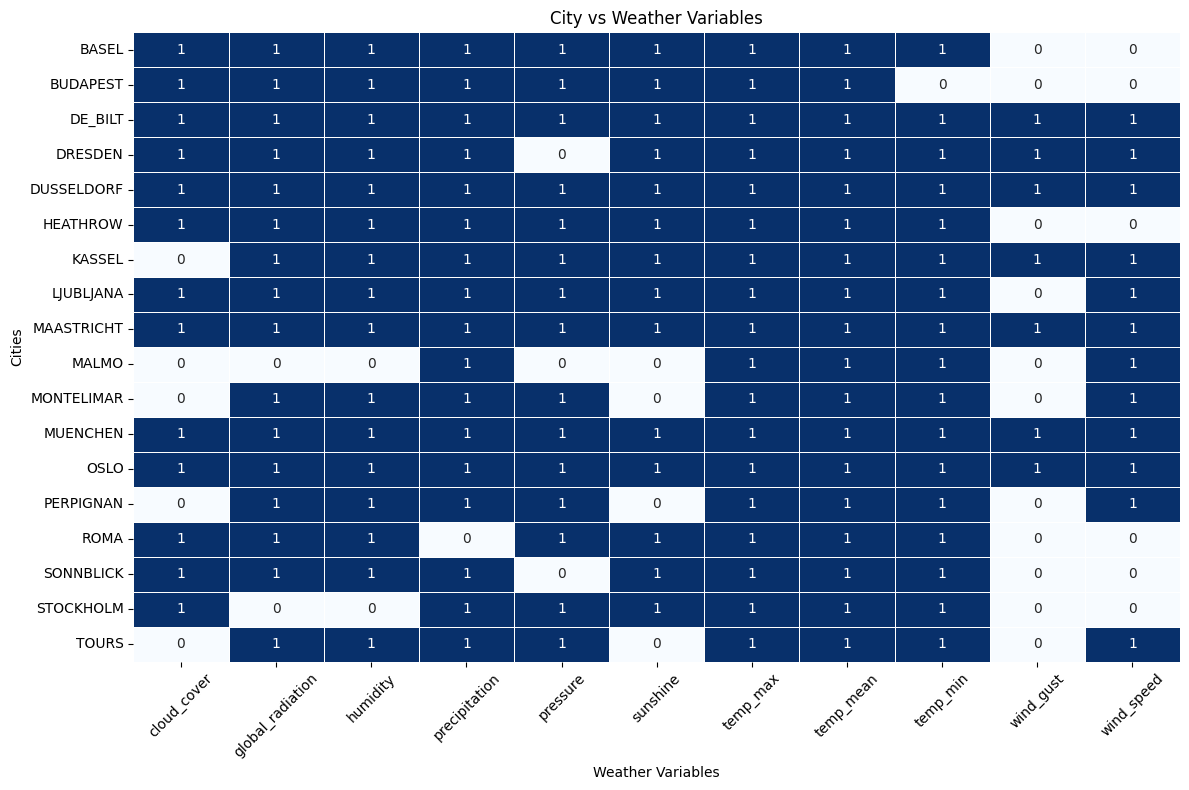

In [8]:
# Cities are rows and variables are columns, populated with 0/1
data_matrix = pd.DataFrame(0, index=cities, columns=variable_list)

for city, var_list in city_variable_dict.items():
    for var in var_list:
        data_matrix.loc[city, var] = 1

plt.figure(figsize=(12, 8))
sns.heatmap(data_matrix, annot=True, cmap="Blues", cbar=False, linewidths=0.5)
plt.title('City vs Weather Variables')
plt.xlabel('Weather Variables')
plt.ylabel('Cities')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

As there are 18 cities, building a generalizable model requires a more compact and scalable feature space.

Efficient Feature Space: The number of features remains constant, regardless of the number of cities, simplifying the model and avoiding unnecessary complexity.

Improved Generalization: The model generalizes more effectively since the feature structure stays consistent, with the city treated as just one additional feature.

Scalability: This approach scales efficiently when handling many cities or expanding the model to include new ones.

Categorical Encoding: The city column can easily be encoded as a categorical feature (e.g., using one-hot encoding or embeddings) without significantly increasing the feature space.

Compact Feature Space: Instead of generating a separate column for each city-variable combination, you only need one set of columns for weather variables, which significantly reduces dimensionality.

Optimized for Model Training: By minimizing dimensionality, this approach mitigates the curse of dimensionality, making the dataset more efficient for training machine learning models. The city can be encoded using techniques like one-hot encoding or embeddings.

Flexible and Scalable: This structure is highly adaptable, making it easier to add more cities or extend the model to a longer time range.

### Data Reshaping

In [9]:
cities = ['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
          'LJUBLJANA', 'MAASTRICHT', 'MALMO', 'MONTELIMAR', 'MUENCHEN', 'OSLO', 'PERPIGNAN',
          'ROMA', 'SONNBLICK', 'STOCKHOLM', 'TOURS']

weather_variables = ['cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_gust', 'wind_speed']

city_var_pairs = [col for col in df.columns if any(col.startswith(city) for city in cities)]

In [10]:
def extract_city_and_variable(col_name):
    for city in cities:
        if col_name.startswith(city):
            return city, col_name[len(city)+1:]
    return None, None

In [11]:
# Reshape the dataframe to long format
long_format_df = pd.melt(
    df,
    id_vars=['DATE', 'MONTH'],
    value_vars=city_var_pairs,
    var_name='city_variable',
    value_name='value'
)

long_format_df[['city', 'variable']] = long_format_df['city_variable'].apply(lambda x: extract_city_and_variable(x)).apply(pd.Series)
long_format_df.drop(columns=['city_variable'], inplace=True)
reshaped_df = long_format_df.pivot_table(index=['DATE', 'MONTH', 'city'], columns='variable', values='value').reset_index()
reshaped_df.to_csv('reshaped_weather_prediction_dataset.csv', index=False)

## Data Overview (after reshaping)

In [12]:
reshaped_df = pd.read_csv('reshaped_weather_prediction_dataset.csv')
reshaped_df.head()

,DATE,MONTH,city,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_gust,wind_speed
0,20000101,1,BASEL,8.0,0.20,0.89,0.03,1.0286,0.0,3.9,2.9,1.6,NaN,NaN
1,20000101,1,BUDAPEST,3.0,0.52,0.92,0.00,1.0268,3.7,-0.7,-4.9,NaN,NaN,NaN
2,20000101,1,DE_BILT,7.0,0.11,0.97,0.10,1.0240,0.0,8.1,6.1,3.5,8.0,2.5
3,20000101,1,DRESDEN,8.0,0.09,0.89,0.32,NaN,0.0,2.0,1.0,-1.8,7.2,3.2
4,20000101,1,DUSSELDORF,8.0,0.12,0.92,0.22,1.0240,0.0,6.9,4.2,2.5,5.9,2.5


In [13]:
reshaped_df.describe()

,DATE,MONTH,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_gust,wind_speed
count,6.577200e+04,65772.000000,47502.000000,58464.000000,58464.000000,62118.000000,54810.000000,51156.000000,65772.000000,65772.000000,62118.000000,25578.000000,43848.000000
mean,2.004568e+07,6.520799,5.134352,1.365636,0.749453,0.230559,1.015801,5.011234,14.502664,10.387741,6.329399,10.060869,3.333559
std,2.873916e+04,3.449637,2.425100,0.952625,0.139225,0.576820,0.013066,4.427446,9.577590,8.407782,7.579270,3.883862,1.886604
min,2.000010e+07,1.000000,-99.000000,0.010000,0.100000,0.000000,-0.099000,-1.700000,-24.700000,-26.600000,-30.300000,1.500000,0.000000
25%,2.002070e+07,4.000000,3.000000,0.530000,0.660000,0.000000,1.010800,0.600000,7.700000,4.600000,1.300000,7.200000,2.000000
50%,2.004567e+07,7.000000,6.000000,1.180000,0.760000,0.000000,1.016200,4.300000,15.000000,10.900000,6.900000,9.500000,2.900000
75%,2.007070e+07,10.000000,7.000000,2.110000,0.860000,0.200000,1.021400,8.500000,21.600000,16.600000,12.000000,12.100000,4.300000
max,2.010010e+07,12.000000,9.000000,4.420000,1.000000,16.040000,1.051200,24.000000,41.100000,33.100000,26.300000,41.000000,16.300000


In [14]:
reshaped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65772 entries, 0 to 65771
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   DATE              65772 non-null  int64  
 1   MONTH             65772 non-null  int64  
 2   city              65772 non-null  object 
 3   cloud_cover       47502 non-null  float64
 4   global_radiation  58464 non-null  float64
 5   humidity          58464 non-null  float64
 6   precipitation     62118 non-null  float64
 7   pressure          54810 non-null  float64
 8   sunshine          51156 non-null  float64
 9   temp_max          65772 non-null  float64
 10  temp_mean         65772 non-null  float64
 11  temp_min          62118 non-null  float64
 12  wind_gust         25578 non-null  float64
 13  wind_speed        43848 non-null  float64
dtypes: float64(11), int64(2), object(1)
memory usage: 7.0+ MB


In [15]:
reshaped_df.dtypes

,0
DATE,int64
MONTH,int64
city,object
cloud_cover,float64
global_radiation,float64
humidity,float64
precipitation,float64
pressure,float64
sunshine,float64
temp_max,float64


### Confirming dataset is time-based as the dates are unique and ordered chronologically (monotonically increasing) and there are no missing dates

In [16]:
reshaped_df['DATE'] = pd.to_datetime(reshaped_df['DATE'], format='%Y%m%d')

unique_dates = reshaped_df['DATE'].nunique()
total_rows = len(reshaped_df)
date_order_correct = reshaped_df['DATE'].is_monotonic_increasing

date_range = pd.date_range(start=reshaped_df['DATE'].min(), end=reshaped_df['DATE'].max())
missing_dates = date_range.difference(reshaped_df['DATE'].unique())

unique_dates, total_rows, date_order_correct, len(missing_dates), missing_dates[:10]

(3654, 65772, True, 0, DatetimeIndex([], dtype='datetime64[ns]', freq='D'))

## Missing Data Analysis

In [17]:
missing_data = reshaped_df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

,0
cloud_cover,18270
global_radiation,7308
humidity,7308
precipitation,3654
pressure,10962
sunshine,14616
temp_min,3654
wind_gust,40194
wind_speed,21924


In [18]:
missing_data_proportion = reshaped_df.isnull().mean() * 100
missing_data_proportion = missing_data_proportion[missing_data_proportion > 0]
missing_data_proportion = missing_data_proportion.sort_values(ascending=False)
missing_data_proportion_formatted = missing_data_proportion.apply(lambda x: f"{x:.2f}%")
missing_data_proportion_formatted

,0
wind_gust,61.11%
wind_speed,33.33%
cloud_cover,27.78%
sunshine,22.22%
pressure,16.67%
global_radiation,11.11%
humidity,11.11%
precipitation,5.56%
temp_min,5.56%


Variables with Low Missing Data (<10%):

precipitation and temp_min are the least affected by missing data and be left as is, as the low percentage of missing data is unlikely to significantly impact model training.

Variables with Moderate Missing Data (10-30%):
cloud_cover, global_radiation, humidity, pressure, sunshine, and wind_speed fall are moderately affected by missing data.As the dataset has been confirmed to be time-based, time-based imputation is an effective approach.

Forward-fill: The missing values for a variable are filled using the most recent available value (i.e., carry the last known value forward).

Backward-fill: If there are missing values at the beginning of a series, backward-fill can be used to propagate future values backward.

Variables with High Missing Data (>30%):

wind_gust has 61.11% missing data, making it unreliable for use in model training.Given the high percentage of missing data, the variable is dropped from analysis entirely, as attempting to impute such a large portion may introduce bias or noise.

In [19]:
# Drop wind_gust due to high percentage of missing data
reshaped_df = reshaped_df.drop(columns=['wind_gust'])

mean_imputer = SimpleImputer(strategy='mean')
constant_imputer = SimpleImputer(strategy='constant', fill_value=0)
# Using mean imputation for temp_min
reshaped_df['temp_min'] = mean_imputer.fit_transform(reshaped_df[['temp_min']])
# Using constant imputation (0) for precipitation
reshaped_df['precipitation'] = constant_imputer.fit_transform(reshaped_df[['precipitation']])

# Variables with moderate missing data to be imputed
variables_to_impute = ['cloud_cover', 'global_radiation', 'humidity', 'pressure', 'sunshine', 'wind_speed']
# Apply forward-fill to impute missing values
reshaped_df[variables_to_impute] = reshaped_df[variables_to_impute].ffill()
# Apply backward-fill to handle any remaining missing values at the start of the series
reshaped_df[variables_to_impute] = reshaped_df[variables_to_impute].bfill()

In [20]:
reshaped_df.to_csv('reshaped_weather_prediction_dataset.csv', index=False)
reshaped_df

,DATE,MONTH,city,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_speed
0,2000-01-01,1,BASEL,8.0,0.20,0.89,0.03,1.0286,0.0,3.9,2.9,1.600000,2.5
1,2000-01-01,1,BUDAPEST,3.0,0.52,0.92,0.00,1.0268,3.7,-0.7,-4.9,6.329399,2.5
2,2000-01-01,1,DE_BILT,7.0,0.11,0.97,0.10,1.0240,0.0,8.1,6.1,3.500000,2.5
3,2000-01-01,1,DRESDEN,8.0,0.09,0.89,0.32,1.0240,0.0,2.0,1.0,-1.800000,3.2
4,2000-01-01,1,DUSSELDORF,8.0,0.12,0.92,0.22,1.0240,0.0,6.9,4.2,2.500000,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65767,2010-01-01,1,PERPIGNAN,7.0,0.62,0.52,0.00,1.0010,0.0,12.7,11.0,9.300000,9.6
65768,2010-01-01,1,ROMA,3.0,1.56,0.73,0.00,1.0152,7.1,11.2,16.0,9.900000,9.6
65769,2010-01-01,1,SONNBLICK,5.0,0.66,0.89,0.56,1.0152,5.6,-7.9,-9.7,-11.500000,9.6
65770,2010-01-01,1,STOCKHOLM,6.0,0.66,0.89,0.07,1.0068,1.5,-7.0,-7.6,-8.800000,9.6


In [21]:
missing_data = reshaped_df.isnull().sum()
missing_data = missing_data[missing_data > 0]
missing_data

,0


In [22]:
reshaped_df['year'] = reshaped_df['DATE'].dt.year
reshaped_df['month'] = reshaped_df['DATE'].dt.month
reshaped_df['day'] = reshaped_df['DATE'].dt.day
reshaped_df.drop(columns=['DATE', 'MONTH'], inplace=True)
reshaped_df.head()

,city,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_speed,year,month,day
0,BASEL,8.0,0.20,0.89,0.03,1.0286,0.0,3.9,2.9,1.600000,2.5,2000,1,1
1,BUDAPEST,3.0,0.52,0.92,0.00,1.0268,3.7,-0.7,-4.9,6.329399,2.5,2000,1,1
2,DE_BILT,7.0,0.11,0.97,0.10,1.0240,0.0,8.1,6.1,3.500000,2.5,2000,1,1
3,DRESDEN,8.0,0.09,0.89,0.32,1.0240,0.0,2.0,1.0,-1.800000,3.2,2000,1,1
4,DUSSELDORF,8.0,0.12,0.92,0.22,1.0240,0.0,6.9,4.2,2.500000,2.5,2000,1,1


In [23]:
reshaped_df.describe()

,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_speed,year,month,day
count,65772.000000,65772.000000,65772.000000,65772.00000,65772.000000,65772.000000,65772.000000,65772.000000,65772.000000,65772.000000,65772.000000,65772.000000,65772.000000
mean,5.197105,1.374306,0.757622,0.21775,1.015755,4.967343,14.502664,10.387741,6.329399,3.629367,2004.501095,6.520799,15.727422
std,2.453077,0.950957,0.142283,0.56305,0.012451,4.441953,9.577590,8.407782,7.365724,2.051786,2.873732,3.449637,8.803095
min,-99.000000,0.010000,0.100000,0.00000,-0.099000,-1.700000,-24.700000,-26.600000,-30.300000,0.000000,2000.000000,1.000000,1.000000
25%,4.000000,0.540000,0.660000,0.00000,1.010700,0.600000,7.700000,4.600000,1.600000,2.200000,2002.000000,4.000000,8.000000
50%,6.000000,1.200000,0.780000,0.00000,1.016200,4.200000,15.000000,10.900000,6.329399,3.100000,2004.500000,7.000000,16.000000
75%,7.000000,2.110000,0.870000,0.17000,1.021300,8.400000,21.600000,16.600000,11.700000,4.600000,2007.000000,10.000000,23.000000
max,9.000000,4.420000,1.000000,16.04000,1.051200,24.000000,41.100000,33.100000,26.300000,16.300000,2010.000000,12.000000,31.000000


## Feature Distribution and Univariate Analysis

In [24]:
categorical_features = reshaped_df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = reshaped_df.select_dtypes(include=['number']).columns.tolist()

print("Categorical Features:")
print(categorical_features)

print("\nDistinct values for each categorical feature:")
for feature in categorical_features:
    distinct_values = reshaped_df[feature].nunique()
    unique_values = reshaped_df[feature].unique()
    print(f"{feature}: {distinct_values} unique values")
    print(f"Values: {unique_values}")

print("\nNumerical Features:")
print(numerical_features)

Categorical Features:
['city']

Distinct values for each categorical feature:
city: 18 unique values
Values: ['BASEL' 'BUDAPEST' 'DE_BILT' 'DRESDEN' 'DUSSELDORF' 'HEATHROW' 'KASSEL'
 'LJUBLJANA' 'MAASTRICHT' 'MALMO' 'MONTELIMAR' 'MUENCHEN' 'OSLO'
 'PERPIGNAN' 'ROMA' 'SONNBLICK' 'STOCKHOLM' 'TOURS']

Numerical Features:
['cloud_cover', 'global_radiation', 'humidity', 'precipitation', 'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed', 'year', 'month', 'day']


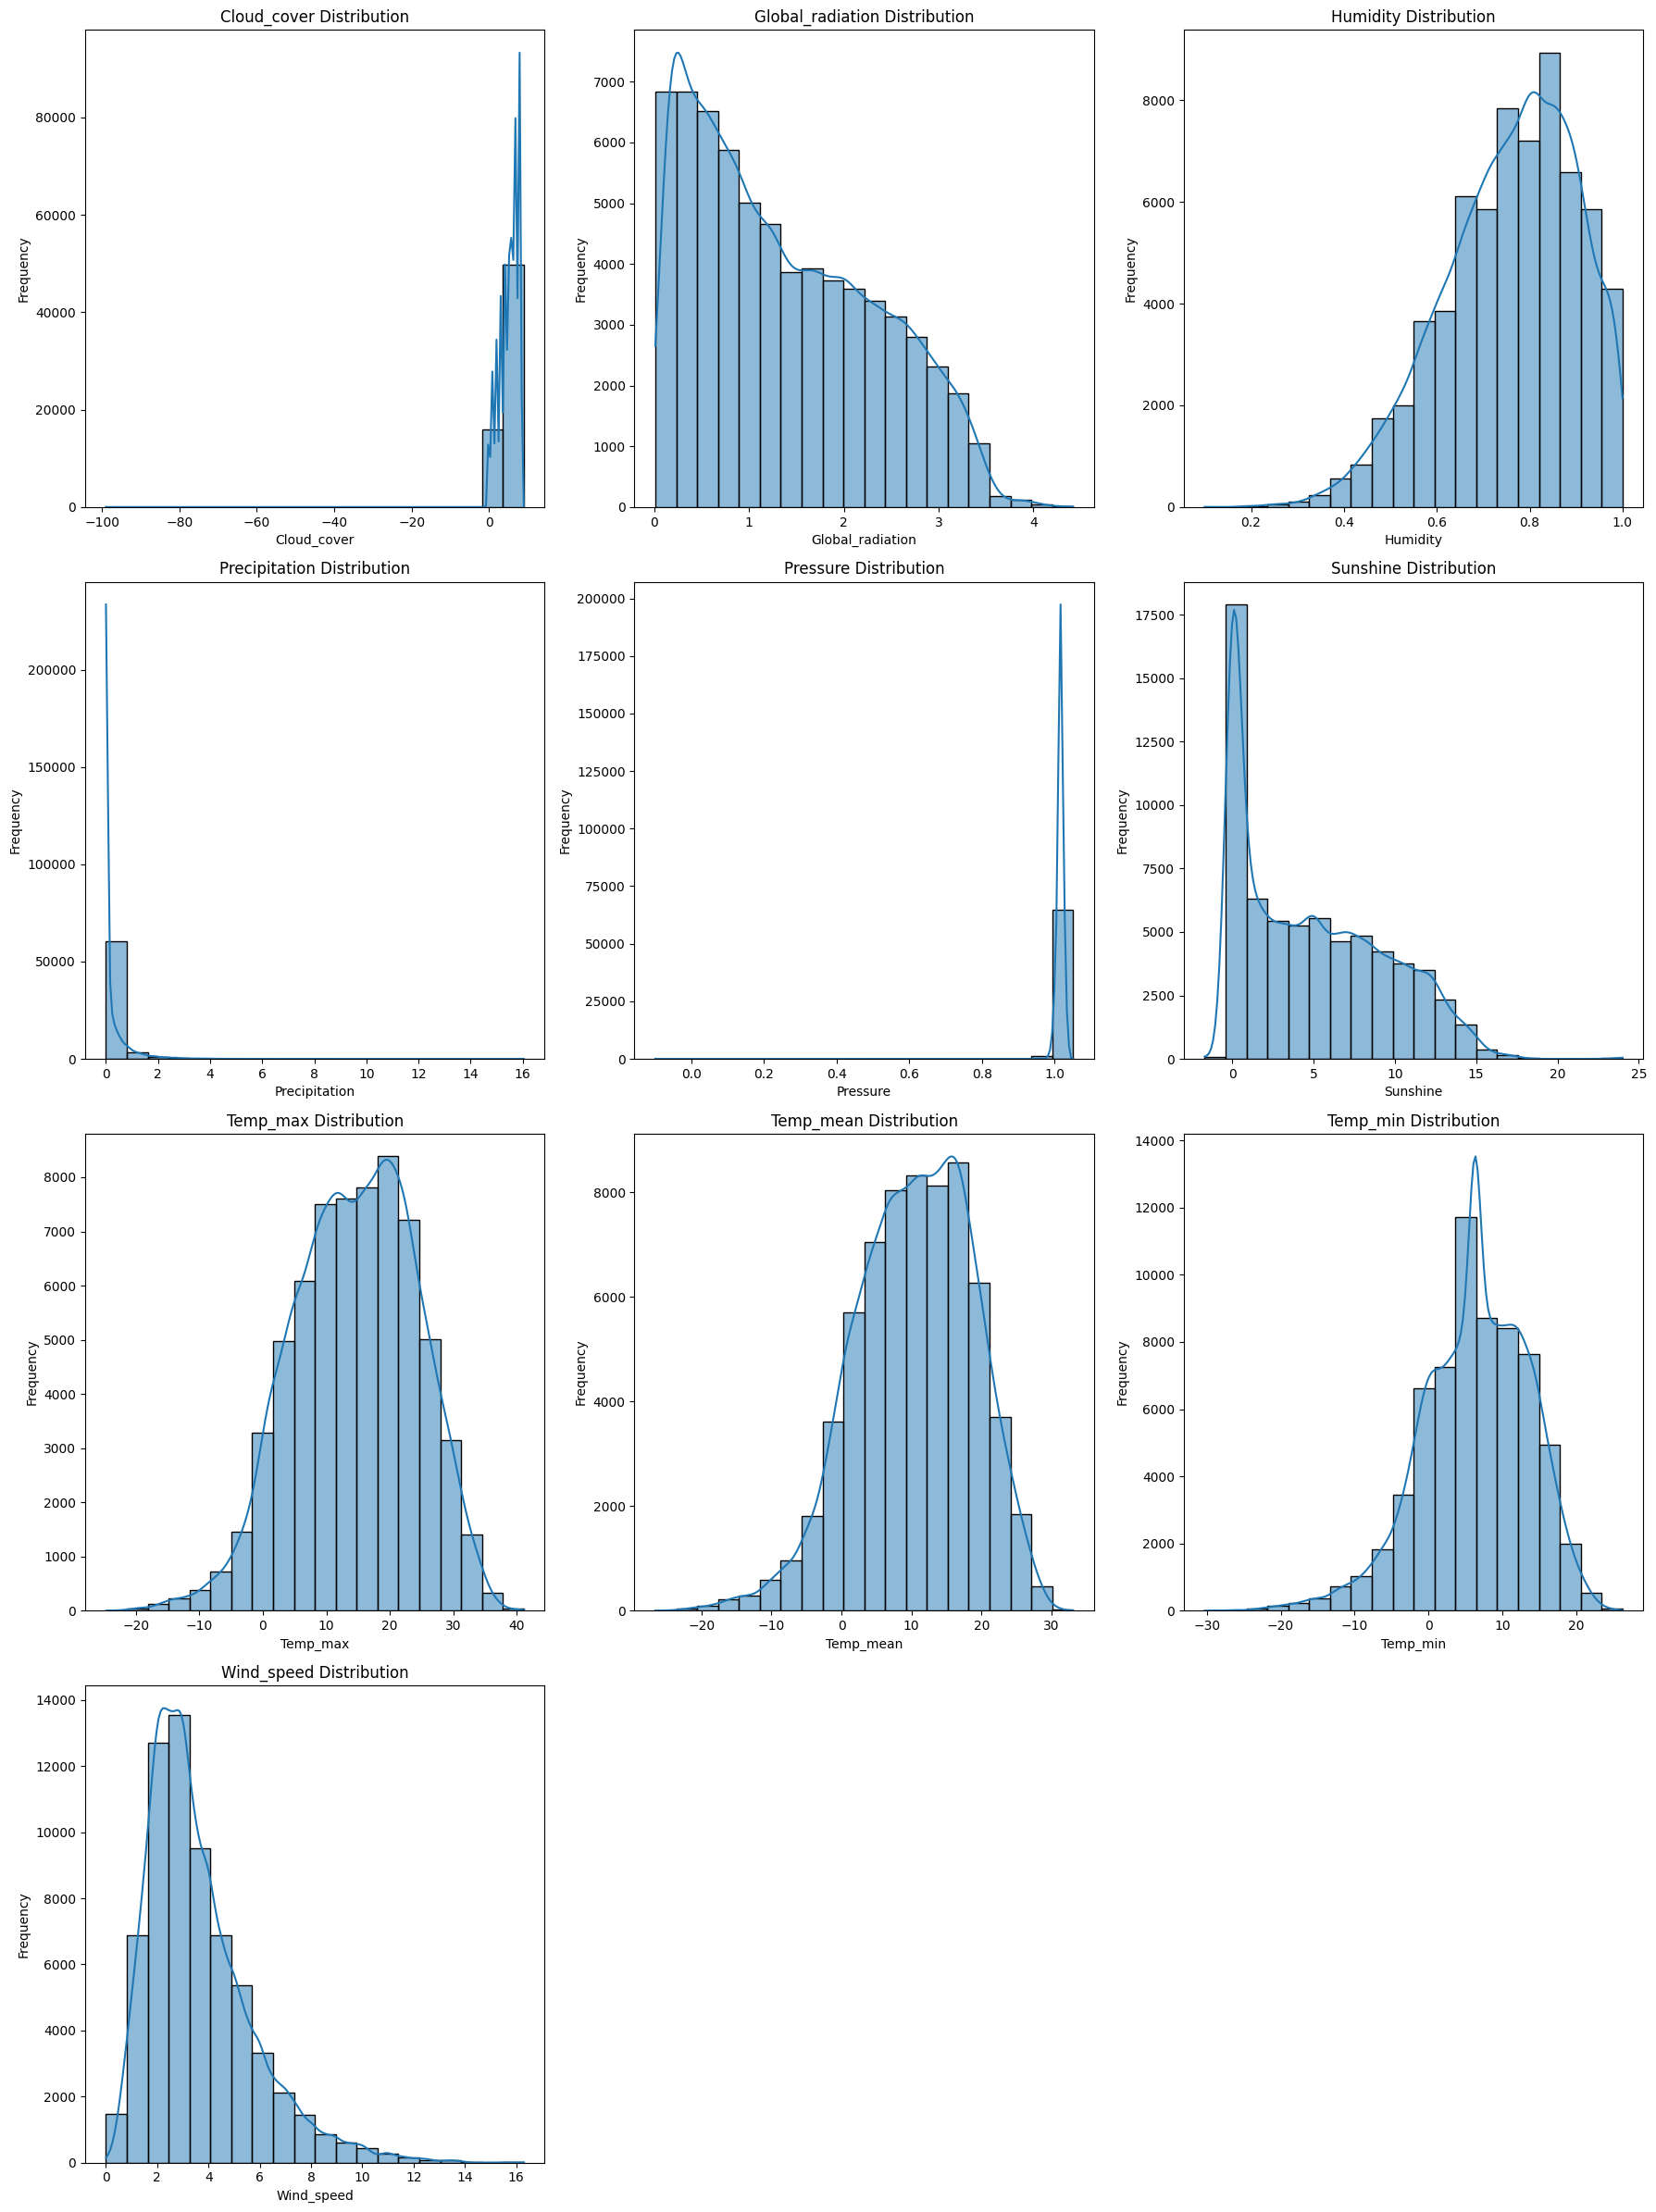

In [25]:
numerical_features = ['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                      'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min',
                      'wind_speed']

num_features = len(numerical_features)
cols = 3
rows = math.ceil(num_features / cols)

fig, axs = plt.subplots(rows, cols, figsize=(18, 6 * rows))
axs = axs.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(reshaped_df[feature], bins=20, kde=True, ax=axs[i])
    axs[i].set_title(f'{feature.capitalize()} Distribution')
    axs[i].set_xlabel(feature.capitalize())
    axs[i].set_ylabel('Frequency')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Shape Analysis (Skewness)

In [26]:
numerical_features = ['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                      'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min',
                      'wind_speed']
skewness = reshaped_df[numerical_features].skew()
print("Skewness of features:\n", skewness)

Skewness of features:
 cloud_cover         -5.153032
global_radiation     0.476130
humidity            -0.539656
precipitation        6.691842
pressure           -41.106925
sunshine             0.566797
temp_max            -0.254646
temp_mean           -0.379185
temp_min            -0.537140
wind_speed           1.298056
dtype: float64


Highly Skewed Features:
	•	cloud_cover, precipitation, pressure, and wind_speed are highly skewed, which could impact the performance of regression models like Linear Regression. These should be the focus for transformation.

Moderate Skewness:
	•	global_radiation, humidity, sunshine, and temp_min may still benefit from some transformation, but their skewness is less extreme.

In [27]:
# Cloud Cover: Reflection + Log
reshaped_df['cloud_cover'] = np.log1p(-reshaped_df['cloud_cover'] + np.max(reshaped_df['cloud_cover']) + 1)

# Global Radiation: Box-Cox
reshaped_df['global_radiation'], _ = boxcox(reshaped_df['global_radiation'] + 1)

# Humidity: Box-Cox
reshaped_df['humidity'], _ = boxcox(reshaped_df['humidity'] + 1)

# Precipitation: Box-Cox
reshaped_df['precipitation'], _ = boxcox(reshaped_df['precipitation'] + 1)

# Pressure: Outlier Removal + Reflection + Log
Q1 = reshaped_df['pressure'].quantile(0.25)
Q3 = reshaped_df['pressure'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
reshaped_df = reshaped_df[(reshaped_df['pressure'] >= lower_bound) & (reshaped_df['pressure'] <= upper_bound)]
reshaped_df['pressure'] = np.log1p(-reshaped_df['pressure'] + np.max(reshaped_df['pressure']) + 1)

# Wind Speed: Log
reshaped_df['wind_speed'] = np.log1p(reshaped_df['wind_speed'])

new_skewness = reshaped_df[numerical_features].skew()
print("Skewness after transformation:\n", new_skewness)

Skewness after transformation:
 cloud_cover         0.071484
global_radiation   -0.035149
humidity           -0.055995
precipitation       1.013782
pressure            0.072532
sunshine            0.538563
temp_max           -0.291274
temp_mean          -0.414657
temp_min           -0.566036
wind_speed          0.112916
dtype: float64


The cloud_cover, global_radiation, humidity, pressure, and wind_speed features are now nearly perfectly normalized.

The temperature features are still slightly negatively skewed, but this is acceptable for most modeling scenarios.

The precipitation and sunshine features still have some moderate skewness, but these values are much improved and should not cause significant issues in most models.

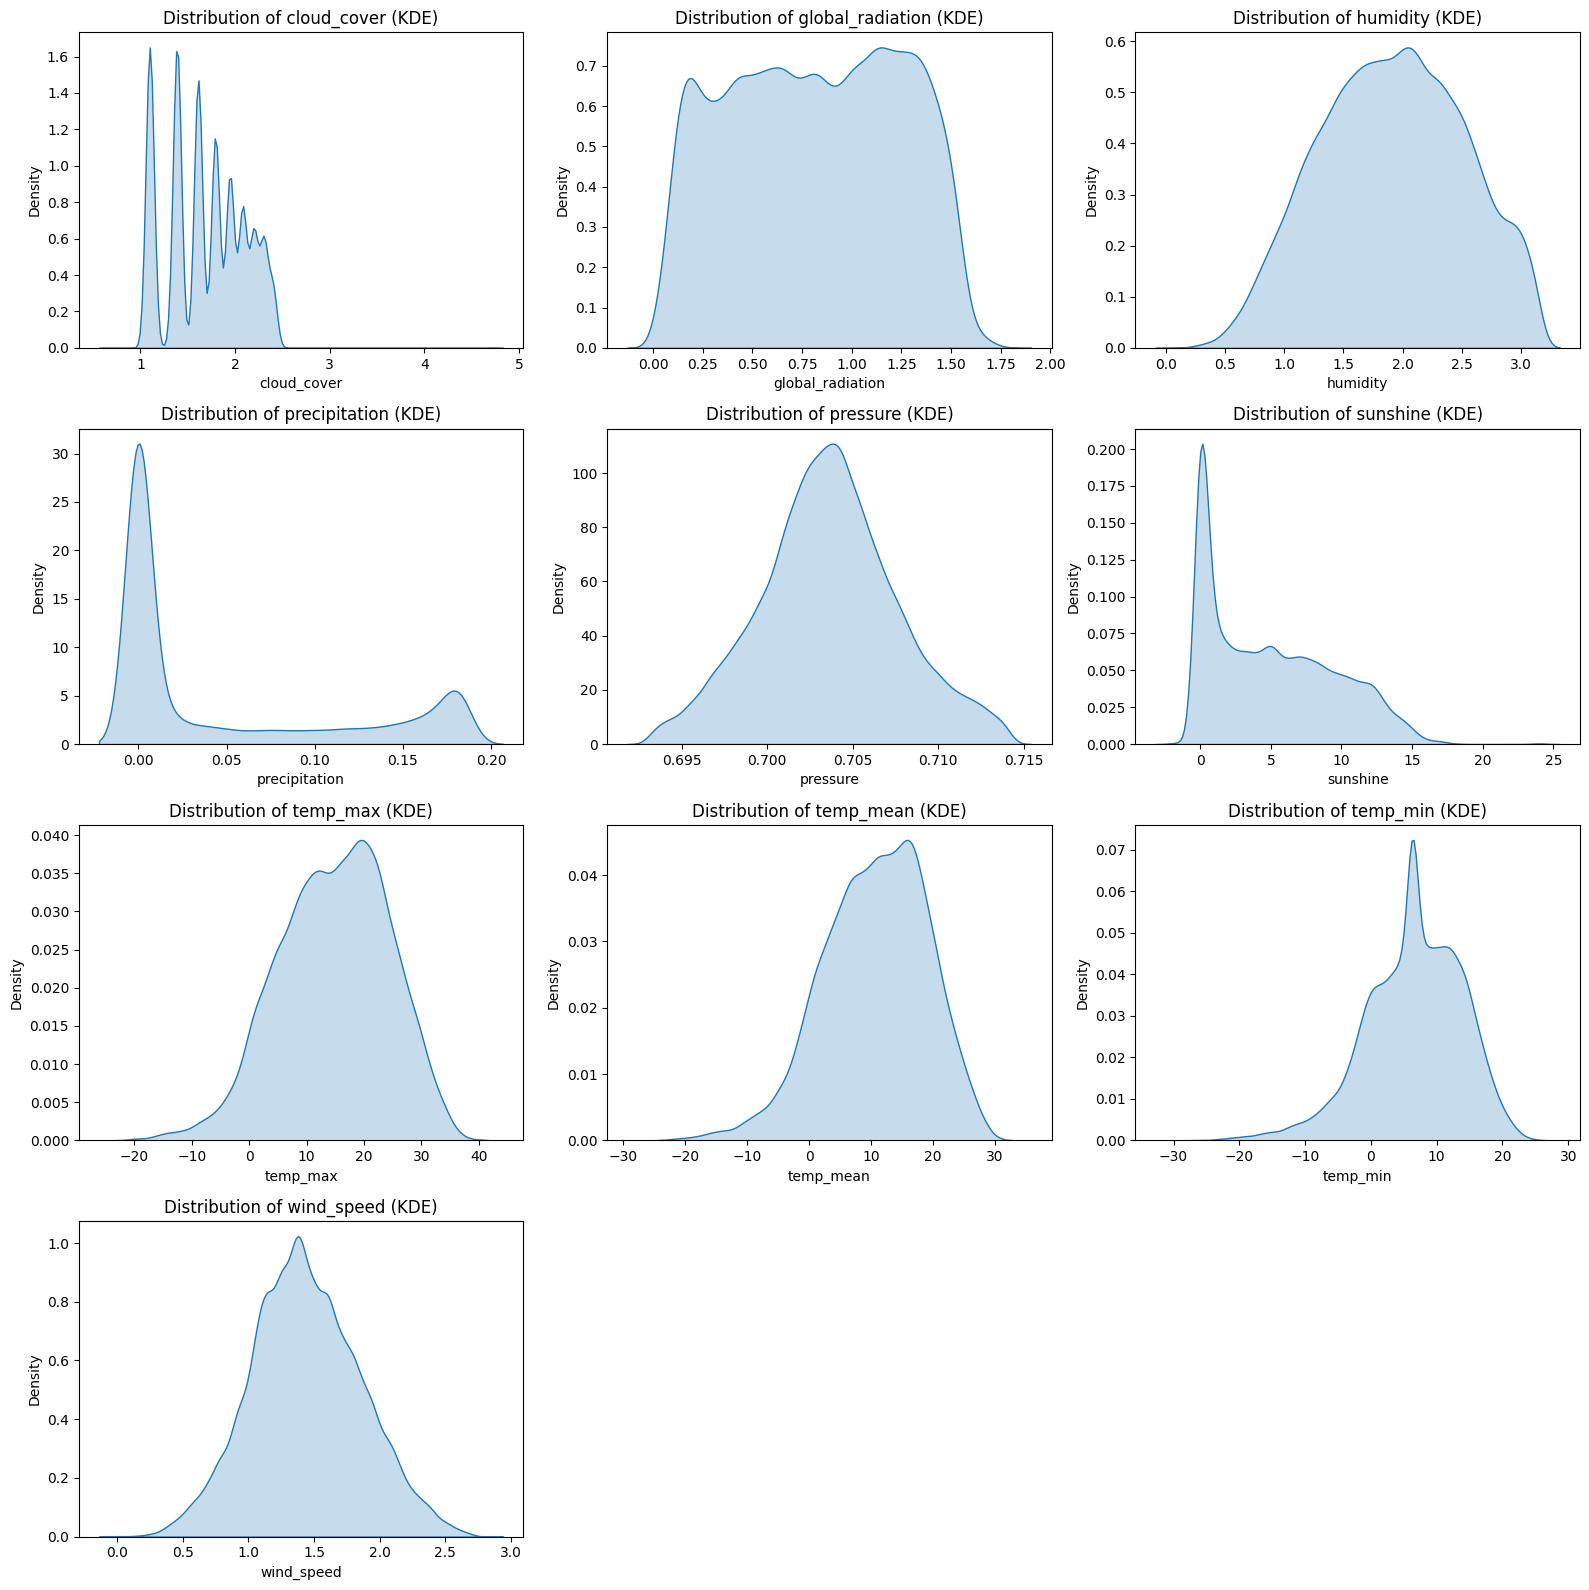

In [28]:
cols = 3
num_features = len(numerical_features)
rows = (num_features // cols) + 1 if num_features % cols != 0 else num_features // cols
plt.figure(figsize=(16, 4 * rows))

for i, feature in enumerate(numerical_features, 1):
    plt.subplot(rows, cols, i)
    sns.kdeplot(reshaped_df[feature], shade=True)
    plt.title(f'Distribution of {feature} (KDE)')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

### Outlier Analysis

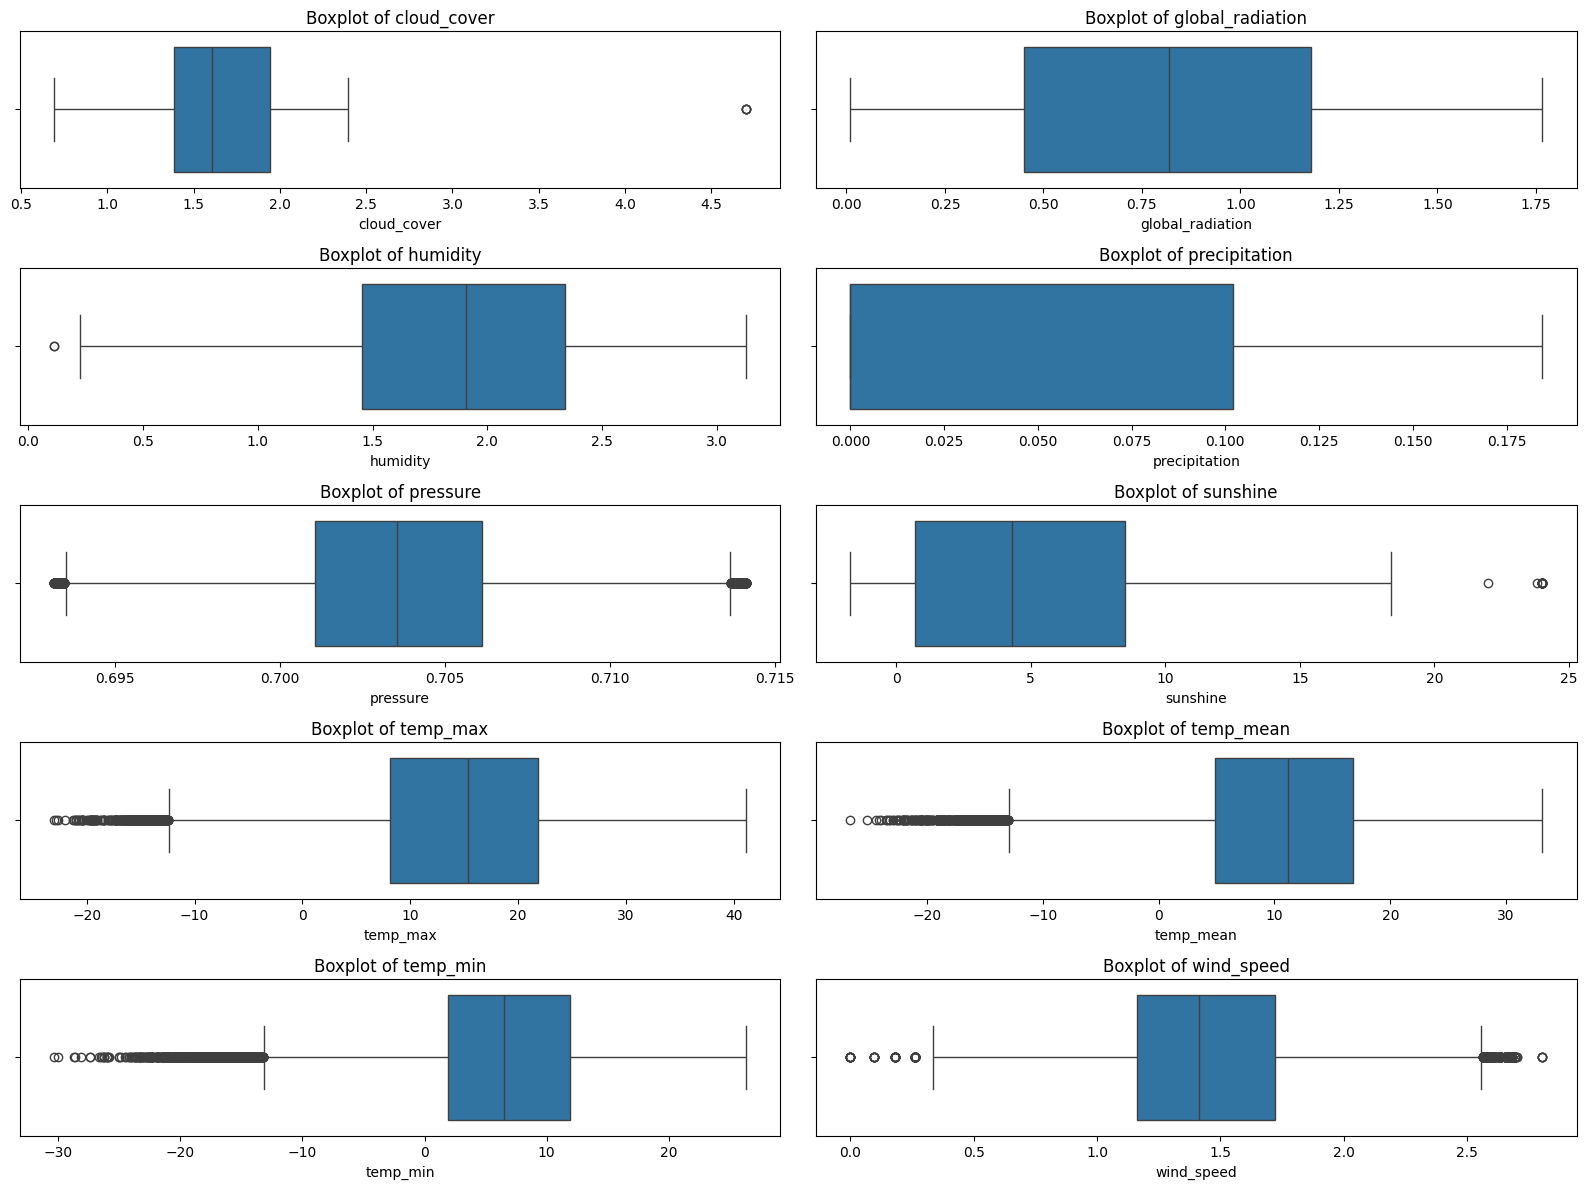

In [29]:
plt.figure(figsize=(16, 12))
for i, feature in enumerate(['cloud_cover', 'global_radiation', 'humidity',
                             'precipitation', 'pressure', 'sunshine',
                             'temp_max', 'temp_mean', 'temp_min', 'wind_speed'], 1):
    plt.subplot(5, 2, i)
    sns.boxplot(x=reshaped_df[feature])
    plt.title(f'Boxplot of {feature}')
plt.tight_layout()
plt.show()

In [30]:
def calculate_iqr_bounds(df, column):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Calculate the outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return lower_bound, upper_bound

for feature in ['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed']:
    lower, upper = calculate_iqr_bounds(reshaped_df, feature)
    print(f"{feature} has bounds - Lower Bound: {lower}, Upper Bound: {upper}")

cloud_cover has bounds - Lower Bound: 0.5468706792167566, Upper Bound: 2.7853338309584474
global_radiation has bounds - Lower Bound: -0.6432767211596121, Upper Bound: 2.271607157130098
humidity has bounds - Lower Bound: 0.1303760967594838, Upper Bound: 3.6650693595256616
precipitation has bounds - Lower Bound: -0.15293569375187144, Upper Bound: 0.25489282291978577
pressure has bounds - Lower Bound: 0.6934952200856492, Upper Bound: 0.7136832886685598
sunshine has bounds - Lower Bound: -11.0, Upper Bound: 20.2
temp_max has bounds - Lower Bound: -12.450000000000001, Upper Bound: 42.35
temp_mean has bounds - Lower Bound: -12.950000000000001, Upper Bound: 34.650000000000006
temp_min has bounds - Lower Bound: -13.1, Upper Bound: 26.9
wind_speed has bounds - Lower Bound: 0.3237271279025469, Upper Bound: 2.5621902796442377


No outlier capping or removal required:

Cloud cover usually ranges from 0 (no cloud cover) to around 8 (completely overcast). The outliers detected here might not represent erroneous data but could indicate low cloud cover conditions. Since the upper bound is 2.79, extreme cloud cover values (close to fully overcast) are not flagged as outliers.

Humidity is typically expressed as a percentage (0%–100%). Depending on the transformation applied, values near 0.13 may represent very low humidity levels, which could occur in extremely dry climates. Upper values may represent high-humidity conditions, potentially caused by local weather.

Outlier capping required:
Temperature Features (temp_max, temp_mean, temp_min): These features have many outliers, but they may be valid extremes that represent important weather events and are extreme value capped as they are part of normal seasonal variation or extreme weather.

Wind speed typically follows a log-normal distribution, with most values clustering near the lower end and some extreme wind events. Outliers might represent strong winds or storms.

Outlier removal:
Sunshine is typically measured in hours per day. Negative values don’t make sense in this context and could represent erroneous entries.

In [31]:
def cap_outliers(df, column, lower_bound, upper_bound):
    df[column] = np.clip(df[column], lower_bound, upper_bound)
    return df

capping_features = ['temp_max', 'temp_mean', 'temp_min', 'wind_speed']
bounds = {
    'temp_max': (-12.45, 42.35),
    'temp_mean': (-12.95, 34.65),
    'temp_min': (-13.1, 26.9),
    'wind_speed': (0.32, 2.56)
}

for feature in capping_features:
    lower_bound, upper_bound = bounds[feature]
    reshaped_df = cap_outliers(reshaped_df, feature, lower_bound, upper_bound)

reshaped_df = reshaped_df[reshaped_df['sunshine'] >= 0]

lower_bound_pressure = 0.693
upper_bound_pressure = 0.714
reshaped_df = cap_outliers(reshaped_df, 'pressure', lower_bound_pressure, upper_bound_pressure)

 # No outliers but keeping within these bounds for consistency
bounds_other = {
    'cloud_cover': (0.55, 2.79),
    'humidity': (0.13, 3.67),
    'global_radiation': (-0.64, 2.27)
}

for feature in ['cloud_cover', 'humidity', 'global_radiation']:
    lower_bound, upper_bound = bounds_other[feature]
    reshaped_df = cap_outliers(reshaped_df, feature, lower_bound, upper_bound)

In [32]:
reshaped_df[['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min', 'wind_speed']].describe()

,cloud_cover,global_radiation,humidity,precipitation,pressure,sunshine,temp_max,temp_mean,temp_min,wind_speed
count,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000
mean,1.681970,0.813808,1.910146,0.047922,0.703606,5.041782,14.751528,10.611287,6.532863,1.440297
std,0.398750,0.424183,0.602375,0.068261,0.004005,4.447689,9.520236,8.314566,7.191068,0.415635
min,0.693147,0.009953,0.130000,0.000000,0.693147,0.000000,-12.450000,-12.950000,-13.100000,0.320000
25%,1.386294,0.449805,1.455886,0.000000,0.701066,0.700000,8.100000,4.900000,1.900000,1.163151
50%,1.609438,0.818755,1.909262,0.000000,0.703543,4.400000,15.300000,11.200000,6.500000,1.410987
75%,1.945910,1.178526,2.339559,0.101957,0.706113,8.500000,21.800000,16.800000,11.900000,1.722767
max,2.790000,1.765647,3.126396,0.184452,0.714000,24.000000,41.100000,33.100000,26.300000,2.560000


Transformation Effectiveness: The transformations and outlier handling techniques have ensured that all features fall within realistic, well-distributed ranges. The skewness and outlier issues have been addressed while retaining important weather patterns.

## Time Series Data Visualization

Only the mean temperature is being visualized from the weather feature set, as it is the target variable.

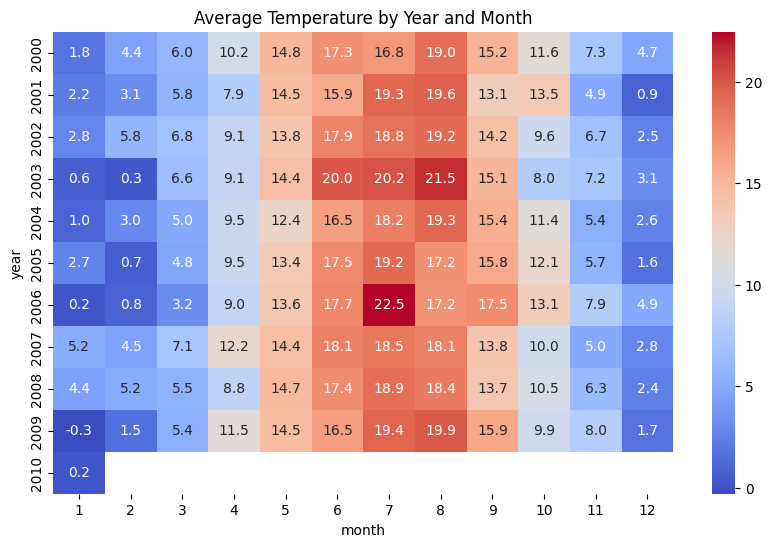

In [33]:
temp_pivot = reshaped_df.pivot_table(values='temp_mean', index='year', columns='month', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(temp_pivot, annot=True, fmt=".1f", cmap='coolwarm')
plt.title('Average Temperature by Year and Month')
plt.show()

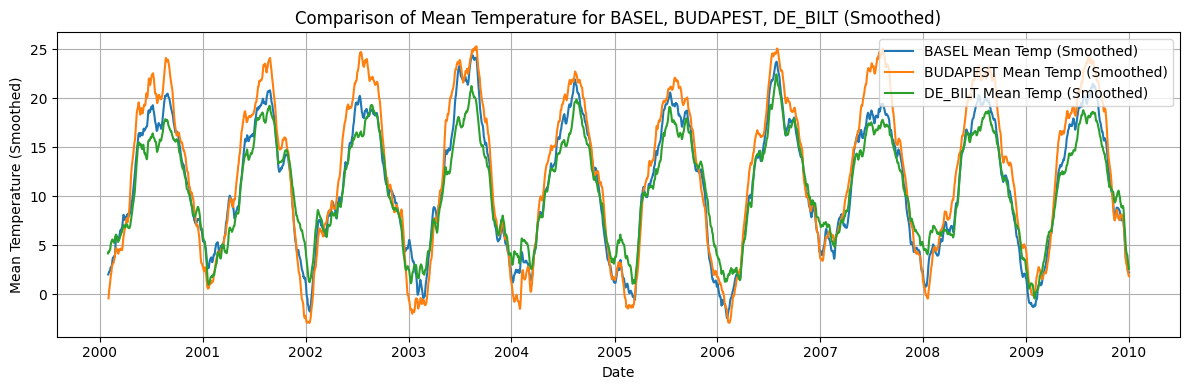

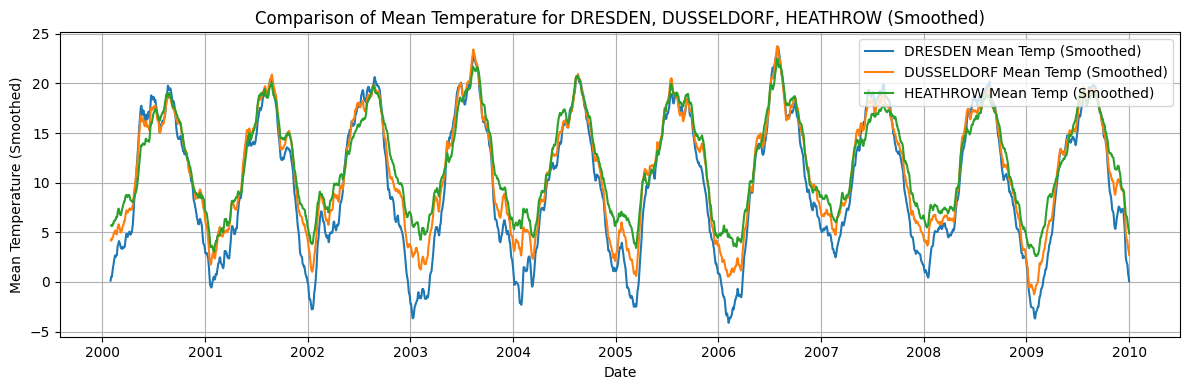

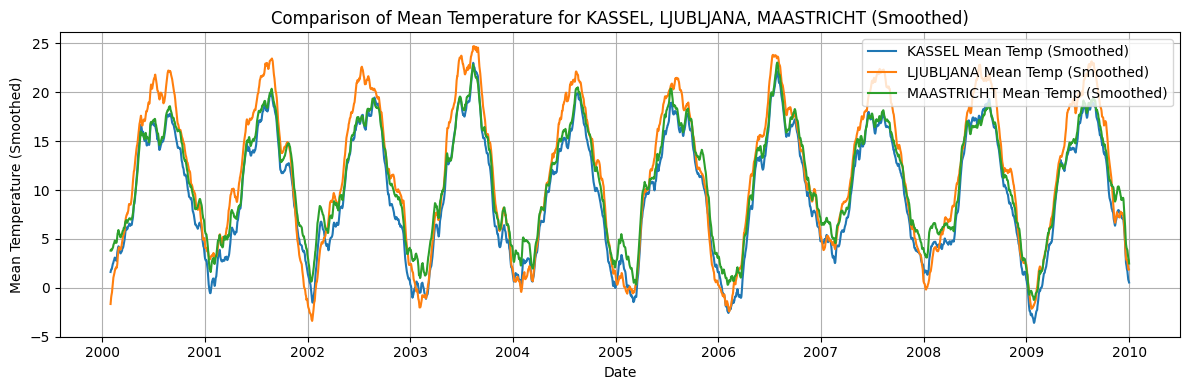

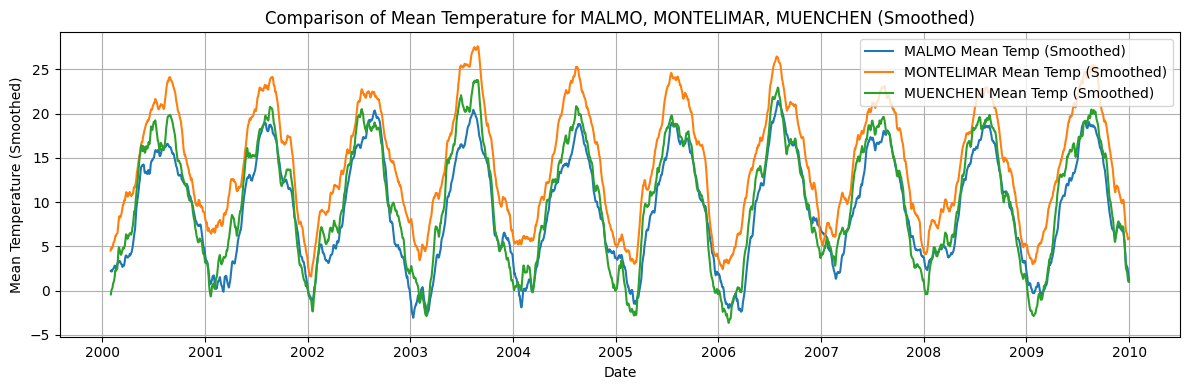

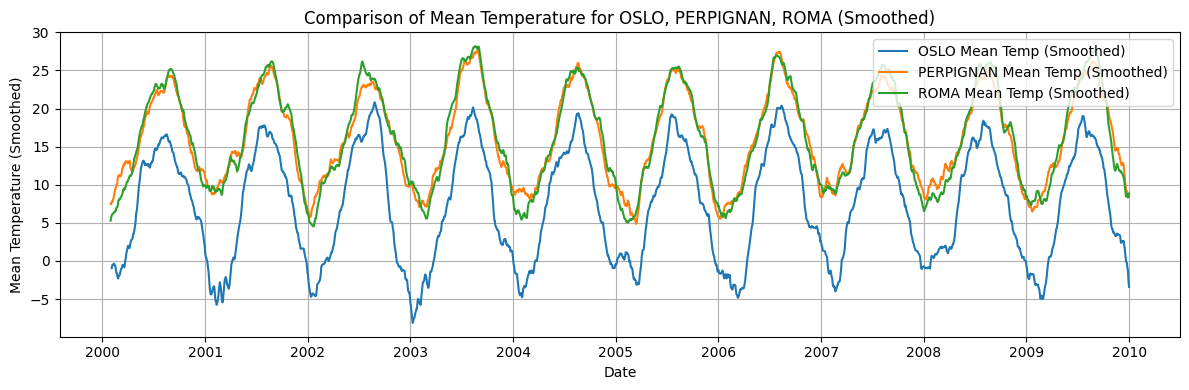

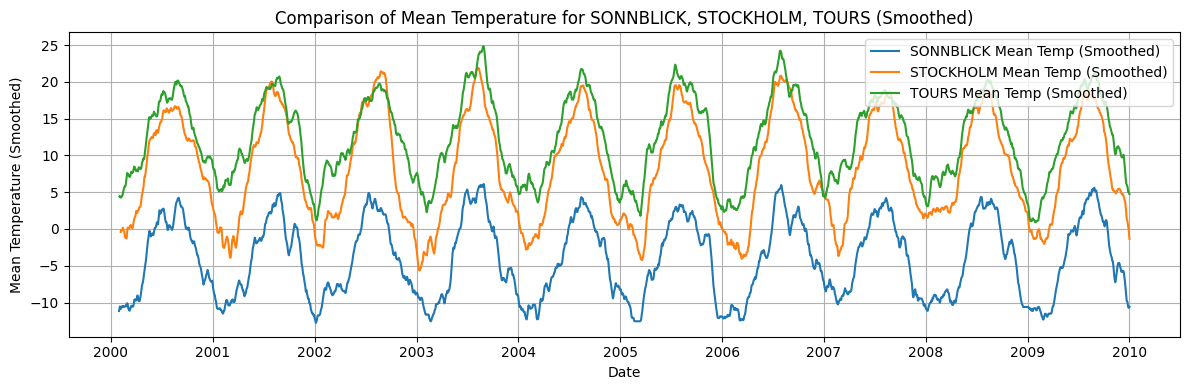

In [34]:
reshaped_df['datetime'] = pd.to_datetime(reshaped_df[['year', 'month', 'day']])

cities_to_compare = ['BASEL', 'BUDAPEST', 'DE_BILT', 'DRESDEN', 'DUSSELDORF', 'HEATHROW', 'KASSEL',
                     'LJUBLJANA', 'MAASTRICHT', 'MALMO', 'MONTELIMAR', 'MUENCHEN', 'OSLO',
                     'PERPIGNAN', 'ROMA', 'SONNBLICK', 'STOCKHOLM', 'TOURS']

window_size = 30

# Group the cities into subsets of 3 and plot for each subset
for i in range(0, len(cities_to_compare), 3):
    subset_cities = cities_to_compare[i:i + 3]
    plt.figure(figsize=(12, 4))

    for city in subset_cities:
        city_data = reshaped_df[reshaped_df['city'] == city]
        city_data_smoothed = city_data[['datetime', 'temp_mean']].copy()
        city_data_smoothed['temp_mean_smoothed'] = city_data['temp_mean'].rolling(window=window_size).mean()
        plt.plot(city_data_smoothed['datetime'], city_data_smoothed['temp_mean_smoothed'], label=f'{city} Mean Temp (Smoothed)')

    plt.title(f'Comparison of Mean Temperature for {", ".join(subset_cities)} (Smoothed)')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (Smoothed)')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

## Multivariate Analysis

### Correlation analysis

Pearson Correlation with Target (temp_mean):
cloud_cover         0.222338
global_radiation    0.558508
humidity           -0.422753
precipitation      -0.133776
pressure            0.084263
sunshine            0.403342
temp_max            0.983488
temp_min            0.937107
wind_speed         -0.062704
Name: temp_mean, dtype: float64

Spearman Correlation with Target (temp_mean):
cloud_cover         0.235580
global_radiation    0.603557
humidity           -0.431106
precipitation      -0.144604
pressure            0.089877
sunshine            0.427984
temp_max            0.981780
temp_min            0.928355
wind_speed         -0.065467
Name: temp_mean, dtype: float64


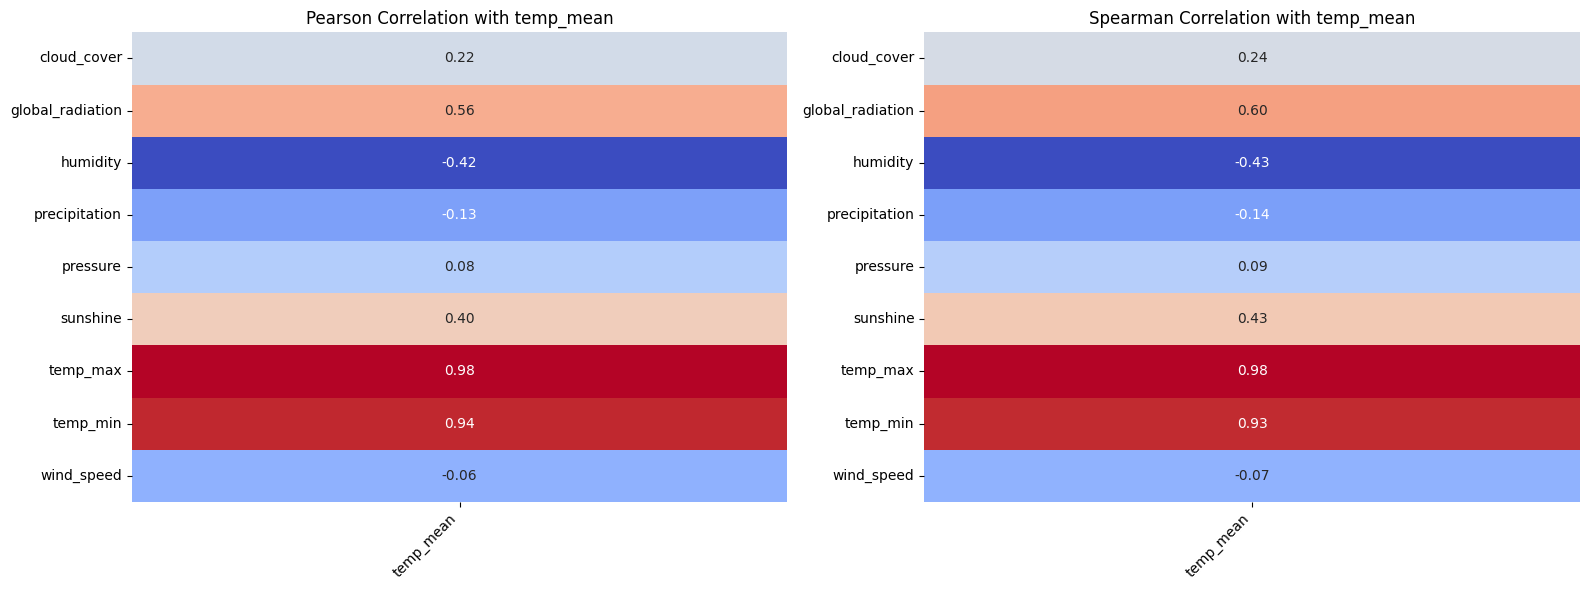

In [35]:
numerical_features = ['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                      'pressure', 'sunshine', 'temp_max', 'temp_min', 'wind_speed']
numerical_df = reshaped_df[numerical_features + ['temp_mean']]

# Compute Pearson and Spearman correlations with the target (temp_mean)
pearson_corr_with_target = numerical_df.corr(method='pearson')['temp_mean'].drop('temp_mean')
spearman_corr_with_target = numerical_df.corr(method='spearman')['temp_mean'].drop('temp_mean')

print("Pearson Correlation with Target (temp_mean):")
print(pearson_corr_with_target)

print("\nSpearman Correlation with Target (temp_mean):")
print(spearman_corr_with_target)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson Correlation heatmap
sns.heatmap(pearson_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0], cbar=False)
axes[0].set_title('Pearson Correlation with temp_mean')
axes[0].set_xticklabels(['temp_mean'], rotation=45, ha='right')
axes[0].set_yticklabels(pearson_corr_with_target.index, rotation=0)

# Plot Spearman Correlation heatmap
sns.heatmap(spearman_corr_with_target.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1], cbar=False)
axes[1].set_title('Spearman Correlation with temp_mean')
axes[1].set_xticklabels(['temp_mean'], rotation=45, ha='right')
axes[1].set_yticklabels(spearman_corr_with_target.index, rotation=0)

plt.tight_layout()
plt.show()

Pearson Correlation Matrix:
                  cloud_cover  global_radiation  humidity  precipitation  \
cloud_cover          1.000000          0.473418 -0.432613      -0.381496   
global_radiation     0.473418          1.000000 -0.565834      -0.272427   
humidity            -0.432613         -0.565834  1.000000       0.387425   
precipitation       -0.381496         -0.272427  0.387425       1.000000   
pressure            -0.206899         -0.032644  0.110348       0.353693   
sunshine             0.779723          0.725607 -0.520450      -0.348982   
temp_max             0.291383          0.615560 -0.470955      -0.173638   
temp_mean            0.222338          0.558508 -0.422753      -0.133776   
temp_min             0.104312          0.427010 -0.299626      -0.057441   
wind_speed          -0.118459         -0.052342 -0.006529       0.121731   

                  pressure  sunshine  temp_max  temp_mean  temp_min  \
cloud_cover      -0.206899  0.779723  0.291383   0.222338  0.104

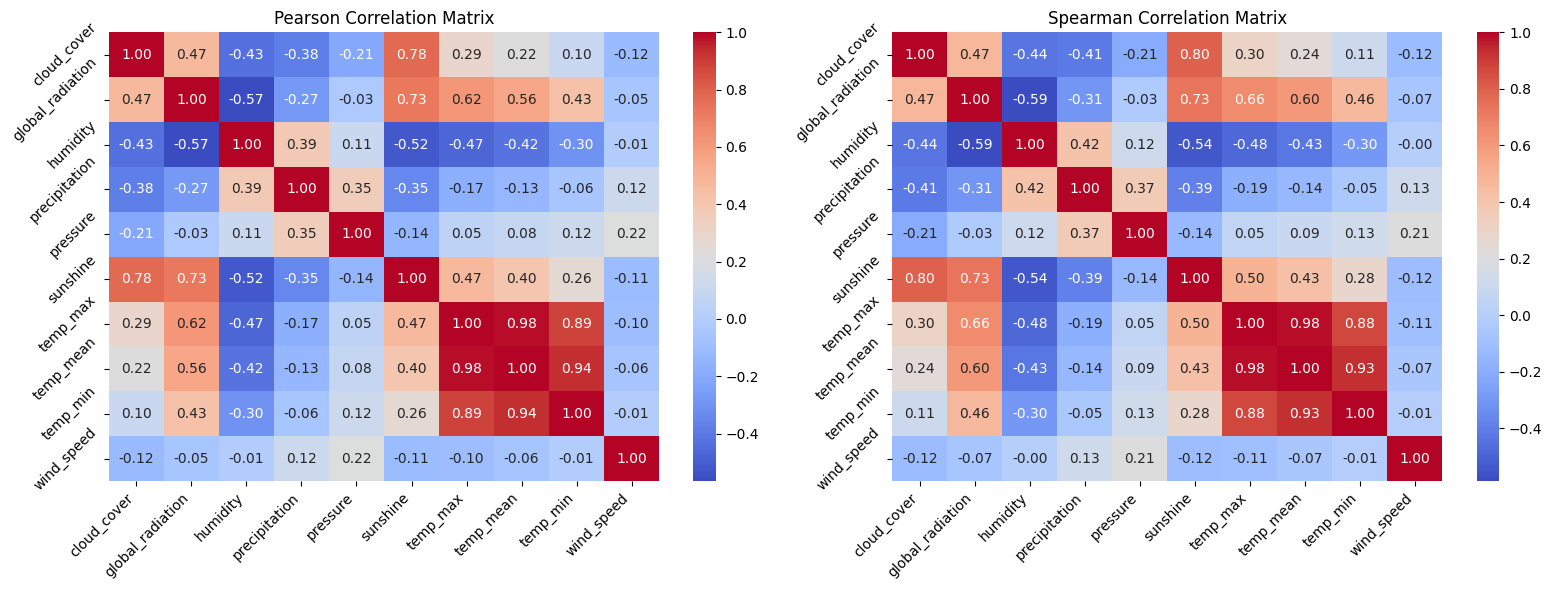

In [36]:
numerical_features = ['cloud_cover', 'global_radiation', 'humidity', 'precipitation',
                      'pressure', 'sunshine', 'temp_max', 'temp_mean', 'temp_min',
                      'wind_speed']
numerical_df = reshaped_df[numerical_features]
pearson_corr_matrix = numerical_df.corr(method='pearson')
spearman_corr_matrix = numerical_df.corr(method='spearman')

print("Pearson Correlation Matrix:")
print(pearson_corr_matrix)

print("\nSpearman Correlation Matrix:")
print(spearman_corr_matrix)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pearson Correlation Heatmap
sns.heatmap(pearson_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[0])
axes[0].set_title('Pearson Correlation Matrix')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=45)

# Spearman Correlation Heatmap
sns.heatmap(spearman_corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', ax=axes[1])
axes[1].set_title('Spearman Correlation Matrix')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Pearson Correlation Matrix Analysis (Linear Relationships)

cloud_cover and sunshine: Strong negative correlation which makes sense as more cloud cover generally means less sunshine.
sunshine and global_radiation : Sunshine hours are strongly related to global radiation, as expected in weather data.
humidity and temp_max: Higher temperatures are often associated with lower humidity, which is typical in dry, hot weather conditions.
Humidity shows consistent negative correlations with temperature (temp_max and temp_mean) and global radiation, which is typical in dry, sunny weather.

Spearman Correlation Matrix Analysis (Rank-Based Relationships)

cloud_cover and sunshine: The strong rank-based relationship here implies that more cloud cover is consistently associated with less sunshine.
temp_max and global_radiation (0.66): The rank correlation is slightly higher than the Pearson correlation, indicating a strong, possibly non-linear relationship.



### Multicollinearity Checks (VIF)

In [37]:
# Calculate VIF for each feature
X = reshaped_df[numerical_features]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            Feature         VIF
0       cloud_cover   53.883527
1  global_radiation   13.976908
2          humidity   19.653375
3     precipitation    1.913281
4          pressure  102.443998
5          sunshine   10.146284
6          temp_max  173.557100
7         temp_mean  195.221852
8          temp_min   21.200437
9        wind_speed   14.500805


VIF is a measure of how much the variance of a regression coefficient is inflated due to multicollinearity among the independent variables.

VIF > 10: Indicates high multicollinearity
VIF > 5: Indicates moderate multicollinearity

Temp_max and Temp_mean are two temperature-related features that are highly collinear, likely due to their close relationship.

### Feature Engineering and Selection

In [38]:
reshaped_df['temp_range'] = reshaped_df['temp_max'] - reshaped_df['temp_min']
reshaped_df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)

In [39]:
reshaped_df.drop(['pressure', 'cloud_cover'], axis=1, inplace=True)
reshaped_df['humidity'] = np.log1p(reshaped_df['humidity'])
reshaped_df['global_radiation'] = np.log1p(reshaped_df['global_radiation'])

In [40]:
updated_numerical_features = ['global_radiation', 'humidity',
                              'precipitation', 'sunshine',
                              'wind_speed', 'temp_range', 'temp_mean']

X = reshaped_df[updated_numerical_features]
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            Feature        VIF
0  global_radiation  15.126018
1          humidity  10.552213
2     precipitation   1.828471
3          sunshine   5.219434
4        wind_speed  10.486531
5        temp_range   8.244007
6         temp_mean   4.427400


## Multivariate Analysis

### Feature Importance

Feature Importance Comparison Across Models:
                  Random Forest  Gradient Boosting   XGBoost
global_radiation       0.393381           0.445765  0.383605
temp_range             0.258329           0.423030  0.346835
humidity               0.107846           0.053749  0.087400
sunshine               0.101817           0.042877  0.079870
wind_speed             0.088592           0.014297  0.048067
precipitation          0.050034           0.020281  0.054224


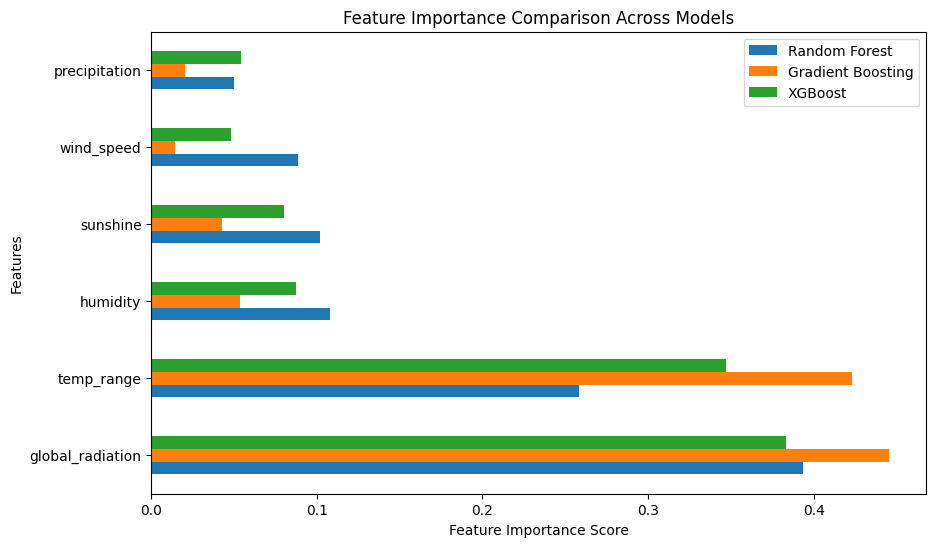

In [41]:
# Define the features and target
selected_features = ['global_radiation', 'humidity', 'precipitation', 'sunshine', 'wind_speed', 'temp_range']

# Prepare data
X = reshaped_df[selected_features]
y = reshaped_df['temp_mean']

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X, y)

gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X, y)

xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X, y)

# Extract feature importance from each model
rf_importance = pd.Series(rf_model.feature_importances_, index=selected_features)
gb_importance = pd.Series(gb_model.feature_importances_, index=selected_features)
xgb_importance = pd.Series(xgb_model.feature_importances_, index=selected_features)

feature_importance_df = pd.DataFrame({
    'Random Forest': rf_importance,
    'Gradient Boosting': gb_importance,
    'XGBoost': xgb_importance
})

feature_importance_df = feature_importance_df.sort_values(by='Random Forest', ascending=False)

print("Feature Importance Comparison Across Models:")
print(feature_importance_df)

feature_importance_df.plot(kind='barh', figsize=(10, 6))
plt.title('Feature Importance Comparison Across Models')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

In [42]:
reshaped_df.head()

,city,global_radiation,humidity,precipitation,sunshine,temp_mean,wind_speed,year,month,day,datetime,temp_range
0,BASEL,0.168204,1.251536,0.027312,0.0,2.9,1.252763,2000,1,1,2000-01-01,2.300000
1,BUDAPEST,0.352941,1.297054,0.000000,3.7,-4.9,1.252763,2000,1,1,2000-01-01,-7.029399
2,DE_BILT,0.099520,1.372461,0.074431,0.0,6.1,1.252763,2000,1,1,2000-01-01,4.600000
3,DRESDEN,0.082841,1.251536,0.143507,0.0,1.0,1.435085,2000,1,1,2000-01-01,3.800000
4,DUSSELDORF,0.107651,1.297054,0.121691,0.0,4.2,1.252763,2000,1,1,2000-01-01,4.400000


In [43]:
reshaped_df[selected_features].describe()

,global_radiation,humidity,precipitation,sunshine,wind_speed,temp_range
count,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000,63850.000000
mean,0.566416,1.045413,0.047922,5.041782,1.440297,8.218665
std,0.244935,0.217644,0.068261,4.447689,0.415635,4.532154
min,0.009904,0.122218,0.000000,0.000000,0.320000,-12.929399
25%,0.371429,0.898488,0.000000,0.700000,1.163151,4.900000
50%,0.598152,1.067900,0.000000,4.400000,1.410987,7.800000
75%,0.778648,1.205839,0.101957,8.500000,1.722767,11.100000
max,1.017275,1.417404,0.184452,24.000000,2.560000,33.770601


## Variable Encoding

In [44]:
# Cyclic encoding for month
reshaped_df['month_sin'] = np.sin(2 * np.pi * reshaped_df['month'] / 12)
reshaped_df['month_cos'] = np.cos(2 * np.pi * reshaped_df['month'] / 12)

#Cyclic encoding for day
reshaped_df['day_sin'] = np.sin(2 * np.pi * reshaped_df['day'] / 31)
reshaped_df['day_cos'] = np.cos(2 * np.pi * reshaped_df['day'] / 31)

# One-hot encoding for city
reshaped_df = pd.get_dummies(reshaped_df, columns=['city'], drop_first=True)

# Drop datetime
reshaped_df.drop(columns=['datetime'], inplace=True)
reshaped_df.head()

,global_radiation,humidity,precipitation,sunshine,temp_mean,wind_speed,year,month,day,temp_range,...,city_MAASTRICHT,city_MALMO,city_MONTELIMAR,city_MUENCHEN,city_OSLO,city_PERPIGNAN,city_ROMA,city_SONNBLICK,city_STOCKHOLM,city_TOURS
0,0.168204,1.251536,0.027312,0.0,2.9,1.252763,2000,1,1,2.300000,...,False,False,False,False,False,False,False,False,False,False
1,0.352941,1.297054,0.000000,3.7,-4.9,1.252763,2000,1,1,-7.029399,...,False,False,False,False,False,False,False,False,False,False
2,0.099520,1.372461,0.074431,0.0,6.1,1.252763,2000,1,1,4.600000,...,False,False,False,False,False,False,False,False,False,False
3,0.082841,1.251536,0.143507,0.0,1.0,1.435085,2000,1,1,3.800000,...,False,False,False,False,False,False,False,False,False,False
4,0.107651,1.297054,0.121691,0.0,4.2,1.252763,2000,1,1,4.400000,...,False,False,False,False,False,False,False,False,False,False


## Modelling

In [45]:
# Evaluate model performance using cross-validation
def evaluate_model_cv(model, X, y, cv_folds=5):
    scoring = {
        'R-squared': make_scorer(r2_score),
        'RMSE': make_scorer(mean_squared_error, squared=False),
        'MAE': make_scorer(mean_absolute_error)
    }

    # Initialize KFold cross-validation
    cv = KFold(n_splits=cv_folds, shuffle=True, random_state=42)
    # Perform cross-validation for each metric
    scores = {}
    for metric, scorer in scoring.items():
        score = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        scores[metric] = np.mean(score)

    return scores

def display_comparison(results):
    results_df = pd.DataFrame(results).T
    print(results_df)

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    results_df[['R-squared']].plot(ax=ax[0], marker='o', linestyle='-', color='blue')
    ax[0].set_title("R-squared Comparison")
    ax[0].set_ylabel("R-squared")
    ax[0].set_xlabel("Models")
    ax[0].set_xticks(range(len(results_df.index)))
    ax[0].set_xticklabels(results_df.index, rotation=45)

    results_df[['RMSE']].plot(ax=ax[1], marker='o', linestyle='-', color='red')
    ax[1].set_title("RMSE Comparison")
    ax[1].set_ylabel("RMSE")
    ax[1].set_xlabel("Models")
    ax[1].set_xticks(range(len(results_df.index)))
    ax[1].set_xticklabels(results_df.index, rotation=45)

    results_df[['MAE']].plot(ax=ax[2], marker='o', linestyle='-', color='green')
    ax[2].set_title("MAE Comparison")
    ax[2].set_ylabel("MAE")
    ax[2].set_xlabel("Models")
    ax[2].set_xticks(range(len(results_df.index)))
    ax[2].set_xticklabels(results_df.index, rotation=45)

    plt.tight_layout()
    plt.show()

def compare_regressors_cv(X, y, cv_folds=5):
    models = {
        'Elastic Net': ElasticNet(random_state=42),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42),
        'XGBoost': XGBRegressor(random_state=42),
        'LightGBM': LGBMRegressor(random_state=42),
        'CatBoost': CatBoostRegressor(random_state=42, verbose=0),
        'AdaBoost': AdaBoostRegressor(random_state=42)
    }
    results = {}

    for name, model in models.items():
        results[name] = evaluate_model_cv(model, X, y, cv_folds=cv_folds)
    display_comparison(results)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 51080, number of used features: 30
[LightGBM] [Info] Start training from score 10.633943
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1314
[LightGBM] [Info] Number of data points in the train set: 51080, number of used features: 30
[LightGBM] [Info] Start training from score 10.607060
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000686 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

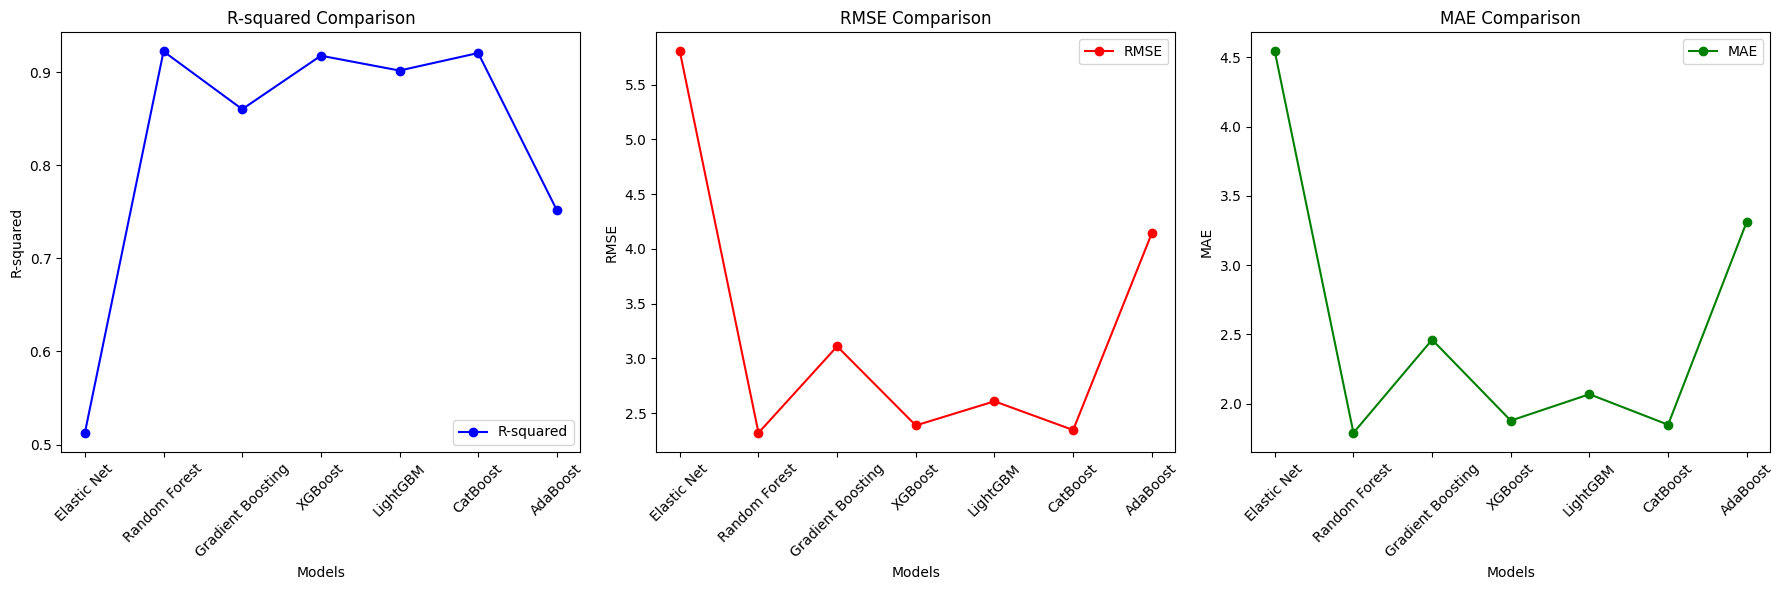

In [46]:
X = reshaped_df.drop(columns=['temp_mean'])  # Features
y = reshaped_df['temp_mean']  # Target variable

# Compare regression models with 5-fold cross-validation
compare_regressors_cv(X, y, cv_folds=5)

### Hyperparameter Tuning

In [47]:
def objective_catboost(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-8, 10.0),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0.0, 1.0),
        'random_strength': trial.suggest_uniform('random_strength', 0.0, 1.0)
    }

    model = CatBoostRegressor(**param, random_state=42, verbose=0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [48]:
study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=50)

print("Best hyperparameters for CatBoost:", study_catboost.best_trial.params)
print("Best RMSE for CatBoost:", study_catboost.best_trial.value)

Best hyperparameters for CatBoost: {'iterations': 993, 'depth': 10, 'learning_rate': 0.1513738643779443, 'l2_leaf_reg': 0.0012560805786143493, 'bagging_temperature': 0.9839017221692411, 'random_strength': 0.8810791992165512}
Best RMSE for CatBoost: 2.0435363844315857


In [49]:
def objective_rf(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 5, 30)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [ ]:
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=50)

print("Best hyperparameters for Random Forest:", study_rf.best_trial.params)
print("Best RMSE for Random Forest:", study_rf.best_trial.value)

In [51]:
def objective_xgb(trial):
    param = {
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'verbosity': 0
    }

    model = xgb.XGBRegressor(**param, random_state=42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

In [52]:
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

print("Best hyperparameters for XGBoost:", study_xgb.best_trial.params)
print("Best RMSE for XGBoost:", study_xgb.best_trial.value)

Best hyperparameters for XGBoost: {'n_estimators': 943, 'max_depth': 13, 'learning_rate': 0.028272667201077812, 'subsample': 0.7280371743630432, 'colsample_bytree': 0.999581710270546}
Best RMSE for XGBoost: 2.000640196482693


Final Evaluation of XGBoost:
RMSE: 2.000640196482693
MAE: 1.549324047602002
R-squared: 0.9421503868232035


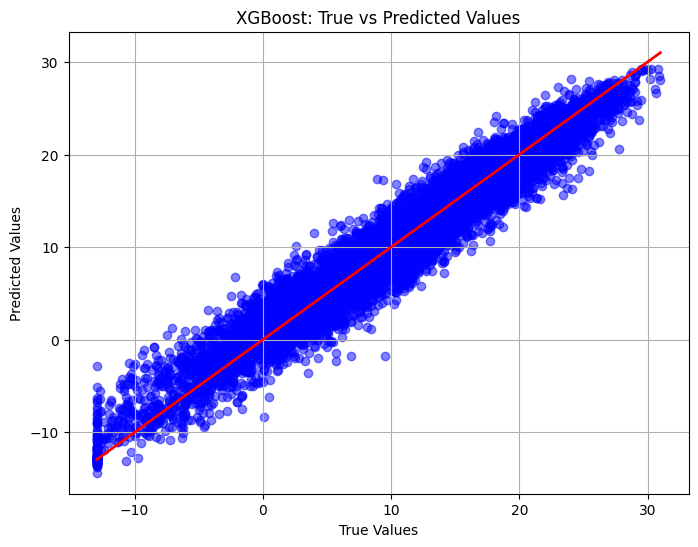

In [53]:
# Final hyperparameters from Optuna
best_params = {
    'n_estimators': 943,
    'max_depth': 13,
    'learning_rate': 0.028272667201077812,
    'subsample': 0.7280371743630432,
    'colsample_bytree': 0.999581710270546,
    'random_state': 42
}

# Initialize XGBoost model with best hyperparameters
xgb_model = xgb.XGBRegressor(**best_params)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Final Evaluation of XGBoost:")
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R-squared: {r2}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", lw=2)
plt.title("XGBoost: True vs Predicted Values")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()

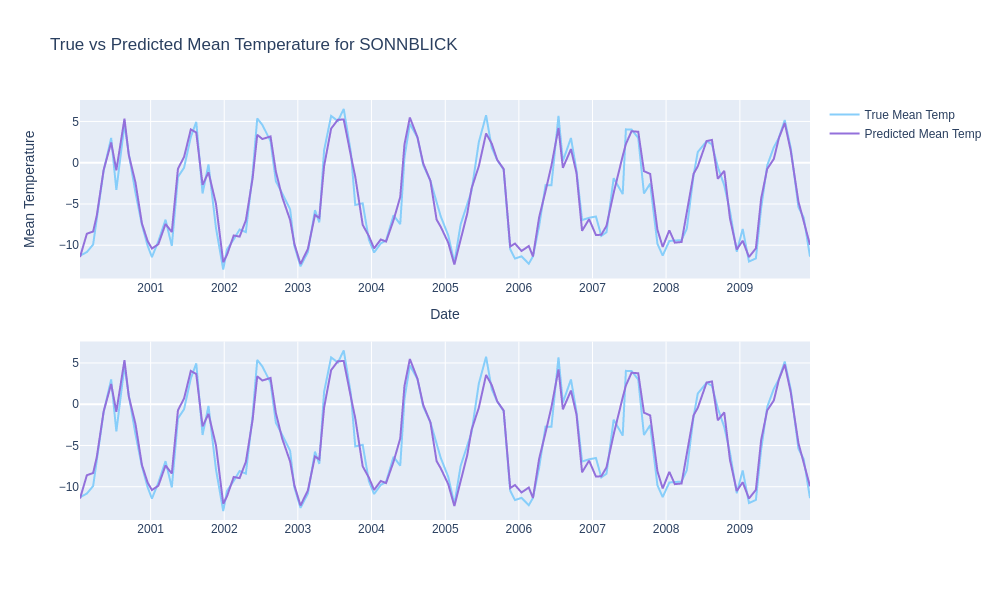

In [58]:
X_test['datetime'] = pd.to_datetime(X_test[['year', 'month', 'day']])

# Grouping by year and month, and calculating the mean for each group
grouped_test = X_test.groupby(['year', 'month'], as_index=False).mean()

# Select the city for which to visualize data
city_to_plot = 'SONNBLICK'
city_test_mask = X_test['city_' + city_to_plot] == 1

y_test_grouped = pd.DataFrame({'Date': X_test[city_test_mask]['datetime'], 'mean_temp': y_test[city_test_mask]})
y_pred_grouped = pd.DataFrame({'Date': X_test[city_test_mask]['datetime'], 'mean_temp': y_pred[city_test_mask]})

y_test_grouped = y_test_grouped.groupby([y_test_grouped['Date'].dt.year, y_test_grouped['Date'].dt.month], as_index=False).mean()
y_pred_grouped = y_pred_grouped.groupby([y_pred_grouped['Date'].dt.year, y_pred_grouped['Date'].dt.month], as_index=False).mean()

fig = make_subplots(rows=2, cols=1)

# Actual mean_temp (Truth)
fig.add_trace(go.Scatter(x=y_test_grouped['Date'], y=y_test_grouped['mean_temp'],name='True Mean Temp', marker_color='LightSkyBlue'), row=1, col=1)
# Predicted mean_temp (Prediction)
fig.add_trace(go.Scatter(x=y_pred_grouped['Date'], y=y_pred_grouped['mean_temp'],name='Predicted Mean Temp', marker_color='MediumPurple'), row=1, col=1)
# Plot for future predictions and comparison
fig.add_trace(go.Scatter(x=y_test_grouped['Date'], y=y_test_grouped['mean_temp'],name='True Mean Temp (Future)', marker_color='LightSkyBlue', showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=y_pred_grouped['Date'], y=y_pred_grouped['mean_temp'],name='Predicted Mean Temp (Future)', marker_color='MediumPurple', showlegend=False), row=2, col=1)

fig.update_layout(title=f"True vs Predicted Mean Temperature for {city_to_plot}",
                  xaxis_title="Date",
                  yaxis_title="Mean Temperature",
                  height=600, width=1000)
fig.show()
fig.write_image("validation_plot.png", engine="kaleido")
Image("validation_plot.png")

In [59]:
reshaped_df.head()

,global_radiation,humidity,precipitation,sunshine,temp_mean,wind_speed,year,month,day,temp_range,...,city_MAASTRICHT,city_MALMO,city_MONTELIMAR,city_MUENCHEN,city_OSLO,city_PERPIGNAN,city_ROMA,city_SONNBLICK,city_STOCKHOLM,city_TOURS
0,0.168204,1.251536,0.027312,0.0,2.9,1.252763,2000,1,1,2.300000,...,False,False,False,False,False,False,False,False,False,False
1,0.352941,1.297054,0.000000,3.7,-4.9,1.252763,2000,1,1,-7.029399,...,False,False,False,False,False,False,False,False,False,False
2,0.099520,1.372461,0.074431,0.0,6.1,1.252763,2000,1,1,4.600000,...,False,False,False,False,False,False,False,False,False,False
3,0.082841,1.251536,0.143507,0.0,1.0,1.435085,2000,1,1,3.800000,...,False,False,False,False,False,False,False,False,False,False
4,0.107651,1.297054,0.121691,0.0,4.2,1.252763,2000,1,1,4.400000,...,False,False,False,False,False,False,False,False,False,False


### GAN for generating weather time series data for testing purposes (Experimental Implementation)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch.cuda.amp import GradScaler, autocast
import torch.nn.utils.spectral_norm as spectral_norm

# weather features and number of features
weather_features = ['global_radiation', 'humidity', 'precipitation', 'sunshine', 'wind_speed', 'temp_range']
n_features = len(weather_features)

# -------------------- 1. Network Definitions --------------------

# Generator network
class Generator(nn.Module):
    def __init__(self, latent_dim, seq_len, n_features):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(1024, 2048),  # Increased layer size
            nn.BatchNorm1d(2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),  # Dropout for regularization
            nn.Linear(2048, 4096),  # Added another layer with more units
            nn.BatchNorm1d(4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, seq_len * n_features),
            nn.Tanh()  # Tanh activation for output normalization
        )

    def forward(self, z):
        x = self.model(z)
        x = x.view(-1, seq_len, n_features)
        return x

# Discriminator network
class Discriminator(nn.Module):
    def __init__(self, seq_len, n_features):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(seq_len * n_features, 2048)),  # Increased layer size
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(2048, 1024)),  # Added extra layers
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(1024, 512)),  # Increased depth
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2),
            spectral_norm(nn.Linear(256, 1))  # Output layer
        )

    def forward(self, x):
        x = x.reshape(-1, seq_len * n_features)
        return self.model(x)

# -------------------- 2. Utility Functions --------------------

# LSGAN loss for Discriminator
def discriminator_loss(real_output, fake_output):
    real_loss = torch.mean((real_output - 1)**2)
    fake_loss = torch.mean(fake_output**2)
    return real_loss + fake_loss

# LSGAN loss for Generator
def generator_loss(fake_output):
    return torch.mean((fake_output - 1)**2)

# Gradient penalty for R1 Regularization
def r1_penalty(real_data, real_output):
    real_grads = torch.autograd.grad(
        outputs=real_output.sum(), inputs=real_data, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    r1_reg = torch.mean(real_grads.pow(2))
    return r1_reg

# Data preprocessing
def preprocess_data(data):
    data_scaler = StandardScaler()
    data = data.to_numpy()
    n_rows = data.shape[0]
    n_features = data.shape[1]
    truncated_rows = (n_rows // 24) * 24
    data = data[:truncated_rows, :]
    data = data_scaler.fit_transform(data.reshape(-1, n_features))
    data = data.reshape(-1, 24, n_features)
    return data, data_scaler

# Generate real data batches
def real_data_gen(weather_data, batch_size):
    idx = np.random.randint(0, len(weather_data) - batch_size)
    return torch.tensor(weather_data[idx:idx + batch_size], dtype=torch.float32)

# Generate random noise for the generator input
def generate_noise(batch_size, latent_dim):
    return torch.randn(batch_size, latent_dim)

# train the discriminator with R1 penalty
def train_discriminator(discriminator, optimizer, real_data, fake_data, lambda_r1=10):
    optimizer.zero_grad()
    fake_data_detached = fake_data.detach()

    real_data_noisy = add_noise_to_data(real_data)
    fake_data_noisy = add_noise_to_data(fake_data_detached)

    # Ensure real_data_noisy requires gradients for the R1 penalty
    real_data_noisy.requires_grad_()

    real_output = discriminator(real_data_noisy)
    fake_output = discriminator(fake_data_noisy)

    d_loss = discriminator_loss(real_output, fake_output)
    r1_loss = r1_penalty(real_data_noisy, real_output)
    total_loss = d_loss + lambda_r1 * r1_loss
    return total_loss

# train the generator
def train_generator(generator, discriminator, optimizer, fake_data):
    optimizer.zero_grad()
    prediction = discriminator(fake_data)
    g_loss = generator_loss(prediction)
    g_loss.backward()
    optimizer.step()
    return g_loss

# -------------------- 3. Training Setup --------------------

# Hyperparameters
seq_len = 24
latent_dim = 128
batch_size = 64
learning_rate_D = 1e-4  # Adjusted learning rate for discriminator
learning_rate_G = 1e-3  # Higher learning rate for generator
num_epochs = 100000  # Increased training duration
lambda_r1 = 10  # Gradient penalty coefficient

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the generator and discriminator
generator = Generator(latent_dim, seq_len, n_features).to(device)
discriminator = Discriminator(seq_len, n_features).to(device)

# Optimizers
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D, betas=(0.5, 0.999), weight_decay=1e-4)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G, betas=(0.5, 0.999), weight_decay=1e-4)

# Load and preprocess weather data
weather_data = reshaped_df[weather_features]
weather_data, data_scaler = preprocess_data(weather_data)

# -------------------- 4. Training Loop --------------------

d_losses = []
g_losses = []

for epoch in range(num_epochs):
    real_data = real_data_gen(weather_data, batch_size).to(device)

    # Generate new noise for each discriminator step
    noise = generate_noise(batch_size, latent_dim).to(device)
    fake_data = generator(noise)

    # Train the discriminator less frequently
    if epoch % 10 == 0:
        optimizer_D.zero_grad()
        d_error = train_discriminator(discriminator, optimizer_D, real_data, fake_data, lambda_r1)
        d_error.backward()
        optimizer_D.step()

    # Train the generator more frequently
    optimizer_G.zero_grad()

    noise = generate_noise(batch_size, latent_dim).to(device)
    fake_data = generator(noise)

    g_error = train_generator(generator, discriminator, optimizer_G, fake_data)

    d_losses.append(d_error.item() if 'd_error' in locals() else 0)
    g_losses.append(g_error.item())

    if epoch % 1000 == 0:
        print(f'Epoch {epoch} | D Loss: {d_error.item():.4f} | G Loss: {g_error.item():.4f}')

        with torch.no_grad():
            synthetic_data = generator(generate_noise(len(weather_data), latent_dim).to(device)).cpu().numpy().reshape(-1, n_features)

plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# -------------------- 5. Generating Synthetic Data --------------------

def generate_full_synthetic_data(generator, real_data, latent_dim, batch_size, device):
    num_real_samples = real_data.shape[0]
    num_batches = num_real_samples // batch_size
    remainder = num_real_samples % batch_size

    synthetic_data_list = []

    # Generate full batches
    for _ in range(num_batches):
        noise = generate_noise(batch_size, latent_dim).to(device)
        fake_data_batch = generator(noise).detach().cpu().numpy()
        synthetic_data_list.append(fake_data_batch)

    # If there are remaining samples to generate
    if remainder > 0:
        noise = generate_noise(remainder, latent_dim).to(device)
        fake_data_batch = generator(noise).detach().cpu().numpy()
        synthetic_data_list.append(fake_data_batch)

    # Concatenate all batches to form the final synthetic dataset
    synthetic_data = np.concatenate(synthetic_data_list, axis=0)

    return synthetic_data

synthetic_data = generate_full_synthetic_data(generator, weather_data, latent_dim, batch_size, device)
assert synthetic_data.shape == weather_data.shape, f"Shape mismatch: {synthetic_data.shape} vs {weather_data.shape}"

In [ ]:
def plot_histograms(real_data, synthetic_data, feature_names):
    num_features = len(feature_names)
    plt.figure(figsize=(15, 10))

    for i in range(num_features):
        plt.subplot(int(np.ceil(num_features / 3)), 3, i + 1)
        plt.hist(real_data[:, i], bins=20, alpha=0.6, label='Real', density=True)
        plt.hist(synthetic_data[:, i], bins=20, alpha=0.6, label='Synthetic', density=True)
        plt.xlim(-4, 4)
        plt.title(feature_names[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_histograms(weather_data, synthetic_data, weather_features)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualization(ori_data, generated_data, analysis):
    if isinstance(ori_data, torch.Tensor):
        ori_data = ori_data.detach().cpu().numpy()
    if isinstance(generated_data, torch.Tensor):
        generated_data = generated_data.detach().cpu().numpy()

    anal_sample_no = min([1000, len(ori_data), len(generated_data)])
    idx = np.random.permutation(len(ori_data))[:anal_sample_no]

    ori_data = ori_data[idx]
    generated_data = generated_data[:anal_sample_no]

    no, seq_len, dim = ori_data.shape

    for i in range(anal_sample_no):
        if i == 0:
            prep_data = np.reshape(np.mean(ori_data[0, :, :], 1), [1, seq_len])
            prep_data_hat = np.reshape(np.mean(generated_data[0, :, :], 1), [1, seq_len])
        else:
            prep_data = np.concatenate((prep_data,
                                        np.reshape(np.mean(ori_data[i, :, :], 1), [1, seq_len])))
            prep_data_hat = np.concatenate((prep_data_hat,
                                            np.reshape(np.mean(generated_data[i, :, :], 1), [1, seq_len])))

    colors = ["red" for i in range(anal_sample_no)] + ["blue" for i in range(anal_sample_no)]

    if analysis == 'pca':
        # PCA Analysis
        pca = PCA(n_components=2)
        pca.fit(prep_data)
        pca_results = pca.transform(prep_data)
        pca_hat_results = pca.transform(prep_data_hat)

        f, ax = plt.subplots(1)
        plt.scatter(pca_results[:, 0], pca_results[:, 1],c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(pca_hat_results[:, 0], pca_hat_results[:, 1], c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")
        ax.legend()
        plt.title('PCA plot')
        plt.xlabel('x-pca')
        plt.ylabel('y-pca')
        plt.show()
    elif analysis == 'tsne':
        prep_data_final = np.concatenate((prep_data, prep_data_hat), axis=0)
        tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
        tsne_results = tsne.fit_transform(prep_data_final)

        f, ax = plt.subplots(1)
        plt.scatter(tsne_results[:anal_sample_no, 0], tsne_results[:anal_sample_no, 1], c=colors[:anal_sample_no], alpha=0.2, label="Original")
        plt.scatter(tsne_results[anal_sample_no:, 0], tsne_results[anal_sample_no:, 1], c=colors[anal_sample_no:], alpha=0.2, label="Synthetic")
        ax.legend()
        plt.title('t-SNE plot')
        plt.xlabel('x-tsne')
        plt.ylabel('y-tsne')
        plt.show()

In [ ]:
visualization(ori_data=weather_data, generated_data=fake_data, analysis='pca')

In [ ]:
visualization(ori_data=weather_data, generated_data=fake_data, analysis='tsne')